# Image Captioning with RNNs
In this exercise you will implement a vanilla recurrent neural networks and use them it to train a model that can generate novel captions for images.

In [4]:
# As usual, a bit of setup
import time, os, json
import numpy as np
import matplotlib.pyplot as plt

from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.rnn_layers import *
from cs231n.captioning_solver import CaptioningSolver
from cs231n.classifiers.rnn import CaptioningRNN
from cs231n.coco_utils import load_coco_data, sample_coco_minibatch, decode_captions
from cs231n.image_utils import image_from_url

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

## Install h5py
The COCO dataset we will be using is stored in HDF5 format. To load HDF5 files, we will need to install the `h5py` Python package. From the command line, run: <br/>
`pip install h5py`  <br/>
If you receive a permissions error, you may need to run the command as root: <br/>
```sudo pip install h5py```

You can also run commands directly from the Jupyter notebook by prefixing the command with the "!" character:

In [5]:
!pip install h5py

# Microsoft COCO
For this exercise we will use the 2014 release of the [Microsoft COCO dataset](http://mscoco.org/) which has become the standard testbed for image captioning. The dataset consists of 80,000 training images and 40,000 validation images, each annotated with 5 captions written by workers on Amazon Mechanical Turk.

You should have already downloaded the data by changing to the `cs231n/datasets` directory and running the script `get_assignment3_data.sh`. If you haven't yet done so, run that script now. Warning: the COCO data download is ~1GB.

We have preprocessed the data and extracted features for you already. For all images we have extracted features from the fc7 layer of the VGG-16 network pretrained on ImageNet; these features are stored in the files `train2014_vgg16_fc7.h5` and `val2014_vgg16_fc7.h5` respectively. To cut down on processing time and memory requirements, we have reduced the dimensionality of the features from 4096 to 512; these features can be found in the files `train2014_vgg16_fc7_pca.h5` and `val2014_vgg16_fc7_pca.h5`.

The raw images take up a lot of space (nearly 20GB) so we have not included them in the download. However all images are taken from Flickr, and URLs of the training and validation images are stored in the files `train2014_urls.txt` and `val2014_urls.txt` respectively. This allows you to download images on the fly for visualization. Since images are downloaded on-the-fly, **you must be connected to the internet to view images**.

Dealing with strings is inefficient, so we will work with an encoded version of the captions. Each word is assigned an integer ID, allowing us to represent a caption by a sequence of integers. The mapping between integer IDs and words is in the file `coco2014_vocab.json`, and you can use the function `decode_captions` from the file `cs231n/coco_utils.py` to convert numpy arrays of integer IDs back into strings.

There are a couple special tokens that we add to the vocabulary. We prepend a special `<START>` token and append an `<END>` token to the beginning and end of each caption respectively. Rare words are replaced with a special `<UNK>` token (for "unknown"). In addition, since we want to train with minibatches containing captions of different lengths, we pad short captions with a special `<NULL>` token after the `<END>` token and don't compute loss or gradient for `<NULL>` tokens. Since they are a bit of a pain, we have taken care of all implementation details around special tokens for you.

You can load all of the MS-COCO data (captions, features, URLs, and vocabulary) using the `load_coco_data` function from the file `cs231n/coco_utils.py`. Run the following cell to do so:

In [6]:
# Load COCO data from disk; this returns a dictionary
# We'll work with dimensionality-reduced features for this notebook, but feel
# free to experiment with the original features by changing the flag below.
data = load_coco_data(pca_features=True)

# Print out all the keys and values from the data dictionary
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

train_captions <class 'numpy.ndarray'> (400135, 17) int32
train_image_idxs <class 'numpy.ndarray'> (400135,) int32
val_captions <class 'numpy.ndarray'> (195954, 17) int32
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
train_features <class 'numpy.ndarray'> (82783, 512) float32
val_features <class 'numpy.ndarray'> (40504, 512) float32
idx_to_word <class 'list'> 1004
word_to_idx <class 'dict'> 1004
train_urls <class 'numpy.ndarray'> (82783,) <U63
val_urls <class 'numpy.ndarray'> (40504,) <U63


## Look at the data
It is always a good idea to look at examples from the dataset before working with it.

You can use the `sample_coco_minibatch` function from the file `cs231n/coco_utils.py` to sample minibatches of data from the data structure returned from `load_coco_data`. Run the following to sample a small minibatch of training data and show the images and their captions. Running it multiple times and looking at the results helps you to get a sense of the dataset.

Note that we decode the captions using the `decode_captions` function and that we download the images on-the-fly using their Flickr URL, so **you must be connected to the internet to view images**.

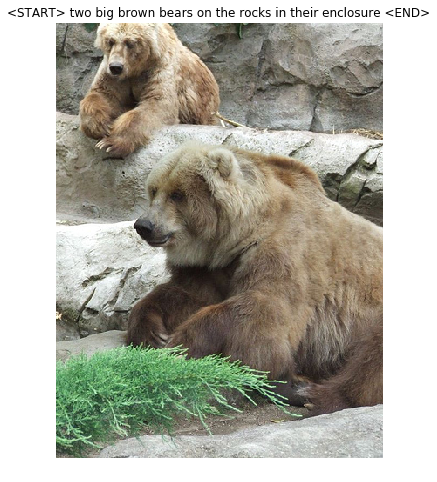

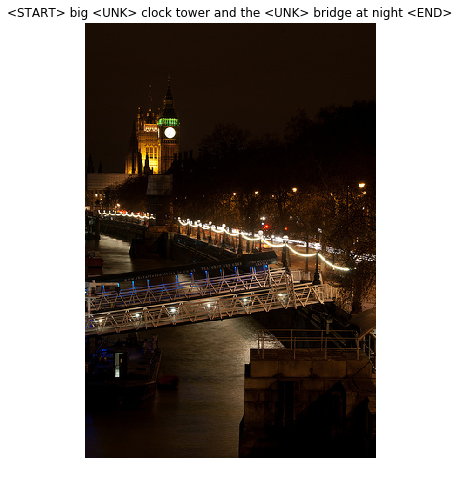

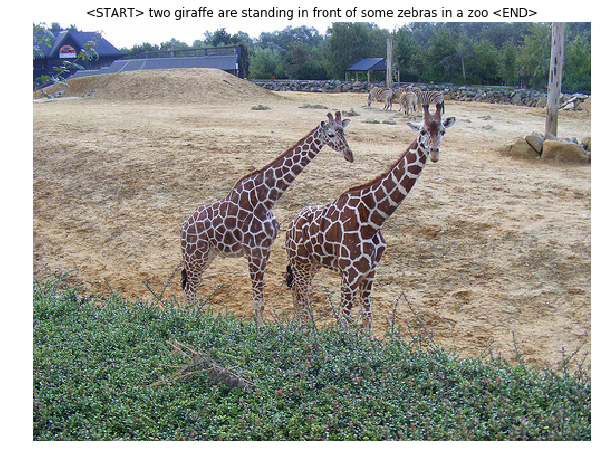

In [7]:
# Sample a minibatch and show the images and captions
batch_size = 3

captions, features, urls = sample_coco_minibatch(data, batch_size=batch_size)
for i, (caption, url) in enumerate(zip(captions, urls)):
    plt.imshow(image_from_url(url))
    plt.axis('off')
    caption_str = decode_captions(caption, data['idx_to_word'])
    plt.title(caption_str)
    plt.show()

# Recurrent Neural Networks
As discussed in lecture, we will use recurrent neural network (RNN) language models for image captioning. The file `cs231n/rnn_layers.py` contains implementations of different layer types that are needed for recurrent neural networks, and the file `cs231n/classifiers/rnn.py` uses these layers to implement an image captioning model.

We will first implement different types of RNN layers in `cs231n/rnn_layers.py`.

# Vanilla RNN: step forward
Open the file `cs231n/rnn_layers.py`. This file implements the forward and backward passes for different types of layers that are commonly used in recurrent neural networks.

First implement the function `rnn_step_forward` which implements the forward pass for a single timestep of a vanilla recurrent neural network. After doing so run the following to check your implementation. You should see errors on the order of e-8 or less.

In [10]:
N, D, H = 3, 10, 4

x = np.linspace(-0.4, 0.7, num=N*D).reshape(N, D)
prev_h = np.linspace(-0.2, 0.5, num=N*H).reshape(N, H)
Wx = np.linspace(-0.1, 0.9, num=D*H).reshape(D, H)
Wh = np.linspace(-0.3, 0.7, num=H*H).reshape(H, H)
b = np.linspace(-0.2, 0.4, num=H)

next_h, _ = rnn_step_forward(x, prev_h, Wx, Wh, b)
expected_next_h = np.asarray([
  [-0.58172089, -0.50182032, -0.41232771, -0.31410098],
  [ 0.66854692,  0.79562378,  0.87755553,  0.92795967],
  [ 0.97934501,  0.99144213,  0.99646691,  0.99854353]])

print('next_h error: ', rel_error(expected_next_h, next_h))

next_h error:  6.292421426471037e-09


# Vanilla RNN: step backward
In the file `cs231n/rnn_layers.py` implement the `rnn_step_backward` function. After doing so run the following to numerically gradient check your implementation. You should see errors on the order of `e-8` or less.

In [25]:
from cs231n.rnn_layers import rnn_step_forward, rnn_step_backward
np.random.seed(231)
N, D, H = 4, 5, 6
x = np.random.randn(N, D)
h = np.random.randn(N, H)
Wx = np.random.randn(D, H)
Wh = np.random.randn(H, H)
b = np.random.randn(H)

out, cache = rnn_step_forward(x, h, Wx, Wh, b)

dnext_h = np.random.randn(*out.shape)

fx = lambda x: rnn_step_forward(x, h, Wx, Wh, b)[0]
fh = lambda prev_h: rnn_step_forward(x, h, Wx, Wh, b)[0]
fWx = lambda Wx: rnn_step_forward(x, h, Wx, Wh, b)[0]
fWh = lambda Wh: rnn_step_forward(x, h, Wx, Wh, b)[0]
fb = lambda b: rnn_step_forward(x, h, Wx, Wh, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dnext_h)
dprev_h_num = eval_numerical_gradient_array(fh, h, dnext_h)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dnext_h)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dnext_h)
db_num = eval_numerical_gradient_array(fb, b, dnext_h)

dx, dprev_h, dWx, dWh, db = rnn_step_backward(dnext_h, cache)

print('dx error: ', rel_error(dx_num, dx))
print('dprev_h error: ', rel_error(dprev_h_num, dprev_h))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  2.99311613693832e-10
dprev_h error:  2.633205333189269e-10
dWx error:  9.684083573724284e-10
dWh error:  3.355162782632426e-10
db error:  1.5956895526227225e-11


# Vanilla RNN: forward
Now that you have implemented the forward and backward passes for a single timestep of a vanilla RNN, you will combine these pieces to implement a RNN that processes an entire sequence of data.

In the file `cs231n/rnn_layers.py`, implement the function `rnn_forward`. This should be implemented using the `rnn_step_forward` function that you defined above. After doing so run the following to check your implementation. You should see errors on the order of `e-7` or less.

In [30]:
N, T, D, H = 2, 3, 4, 5

x = np.linspace(-0.1, 0.3, num=N*T*D).reshape(N, T, D)
h0 = np.linspace(-0.3, 0.1, num=N*H).reshape(N, H)
Wx = np.linspace(-0.2, 0.4, num=D*H).reshape(D, H)
Wh = np.linspace(-0.4, 0.1, num=H*H).reshape(H, H)
b = np.linspace(-0.7, 0.1, num=H)

h, _ = rnn_forward(x, h0, Wx, Wh, b)
expected_h = np.asarray([
  [
    [-0.42070749, -0.27279261, -0.11074945,  0.05740409,  0.22236251],
    [-0.39525808, -0.22554661, -0.0409454,   0.14649412,  0.32397316],
    [-0.42305111, -0.24223728, -0.04287027,  0.15997045,  0.35014525],
  ],
  [
    [-0.55857474, -0.39065825, -0.19198182,  0.02378408,  0.23735671],
    [-0.27150199, -0.07088804,  0.13562939,  0.33099728,  0.50158768],
    [-0.51014825, -0.30524429, -0.06755202,  0.17806392,  0.40333043]]])
print('h error: ', rel_error(expected_h, h))

h error:  7.728466180186066e-08


# Vanilla RNN: backward
In the file `cs231n/rnn_layers.py`, implement the backward pass for a vanilla RNN in the function `rnn_backward`. This should run back-propagation over the entire sequence, making calls to the `rnn_step_backward` function that you defined earlier. You should see errors on the order of e-6 or less.

In [50]:
np.random.seed(231)

N, D, T, H = 2, 3, 10, 5

x = np.random.randn(N, T, D)
h0 = np.random.randn(N, H)
Wx = np.random.randn(D, H)
Wh = np.random.randn(H, H)
b = np.random.randn(H)

out, cache = rnn_forward(x, h0, Wx, Wh, b)

dout = np.random.randn(*out.shape)

dx, dh0, dWx, dWh, db = rnn_backward(dout, cache)

fx = lambda x: rnn_forward(x, h0, Wx, Wh, b)[0]
fh0 = lambda h0: rnn_forward(x, h0, Wx, Wh, b)[0]
fWx = lambda Wx: rnn_forward(x, h0, Wx, Wh, b)[0]
fWh = lambda Wh: rnn_forward(x, h0, Wx, Wh, b)[0]
fb = lambda b: rnn_forward(x, h0, Wx, Wh, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
dh0_num = eval_numerical_gradient_array(fh0, h0, dout)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dout)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dout)
db_num = eval_numerical_gradient_array(fb, b, dout)

print('dx error: ', rel_error(dx_num, dx))
print('dh0 error: ', rel_error(dh0_num, dh0))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

[ 0.43896582 12.79208793 10.66581124 -1.71172585  0.81850342]
dx error:  2.3969112188524054e-09
dh0 error:  3.3796875007867145e-09
dWx error:  7.221000108504998e-09
dWh error:  1.284586847530015e-07
db error:  4.675767378424171e-10


# Word embedding: forward
In deep learning systems, we commonly represent words using vectors. Each word of the vocabulary will be associated with a vector, and these vectors will be learned jointly with the rest of the system.

In the file `cs231n/rnn_layers.py`, implement the function `word_embedding_forward` to convert words (represented by integers) into vectors. Run the following to check your implementation. You should see an error on the order of `e-8` or less.

In [53]:
N, T, V, D = 2, 4, 5, 3

x = np.asarray([[0, 3, 1, 2], [2, 1, 0, 3]])
W = np.linspace(0, 1, num=V*D).reshape(V, D)

out, _ = word_embedding_forward(x, W)
expected_out = np.asarray([
 [[ 0.,          0.07142857,  0.14285714],
  [ 0.64285714,  0.71428571,  0.78571429],
  [ 0.21428571,  0.28571429,  0.35714286],
  [ 0.42857143,  0.5,         0.57142857]],
 [[ 0.42857143,  0.5,         0.57142857],
  [ 0.21428571,  0.28571429,  0.35714286],
  [ 0.,          0.07142857,  0.14285714],
  [ 0.64285714,  0.71428571,  0.78571429]]])

print('out error: ', rel_error(expected_out, out))

out error:  1.0000000094736443e-08


# Word embedding: backward
Implement the backward pass for the word embedding function in the function `word_embedding_backward`. After doing so run the following to numerically gradient check your implementation. You should see an error on the order of `e-11` or less.

In [54]:
np.random.seed(231)

N, T, V, D = 50, 3, 5, 6
x = np.random.randint(V, size=(N, T))
W = np.random.randn(V, D)

out, cache = word_embedding_forward(x, W)
dout = np.random.randn(*out.shape)
dW = word_embedding_backward(dout, cache)

f = lambda W: word_embedding_forward(x, W)[0]
dW_num = eval_numerical_gradient_array(f, W, dout)

print('dW error: ', rel_error(dW, dW_num))

dW error:  3.2774595693100364e-12


# Temporal Affine layer
At every timestep we use an affine function to transform the RNN hidden vector at that timestep into scores for each word in the vocabulary. Because this is very similar to the affine layer that you implemented in assignment 2, we have provided this function for you in the `temporal_affine_forward` and `temporal_affine_backward` functions in the file `cs231n/rnn_layers.py`. Run the following to perform numeric gradient checking on the implementation. You should see errors on the order of e-9 or less.

In [55]:
np.random.seed(231)

# Gradient check for temporal affine layer
N, T, D, M = 2, 3, 4, 5
x = np.random.randn(N, T, D)
w = np.random.randn(D, M)
b = np.random.randn(M)

out, cache = temporal_affine_forward(x, w, b)

dout = np.random.randn(*out.shape)

fx = lambda x: temporal_affine_forward(x, w, b)[0]
fw = lambda w: temporal_affine_forward(x, w, b)[0]
fb = lambda b: temporal_affine_forward(x, w, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
dw_num = eval_numerical_gradient_array(fw, w, dout)
db_num = eval_numerical_gradient_array(fb, b, dout)

dx, dw, db = temporal_affine_backward(dout, cache)

print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

dx error:  2.9215854231394017e-10
dw error:  1.5772169135951167e-10
db error:  3.252200556967514e-11


# Temporal Softmax loss
In an RNN language model, at every timestep we produce a score for each word in the vocabulary. We know the ground-truth word at each timestep, so we use a softmax loss function to compute loss and gradient at each timestep. We sum the losses over time and average them over the minibatch.

However there is one wrinkle: since we operate over minibatches and different captions may have different lengths, we append `<NULL>` tokens to the end of each caption so they all have the same length. We don't want these `<NULL>` tokens to count toward the loss or gradient, so in addition to scores and ground-truth labels our loss function also accepts a `mask` array that tells it which elements of the scores count towards the loss.

Since this is very similar to the softmax loss function you implemented in assignment 1, we have implemented this loss function for you; look at the `temporal_softmax_loss` function in the file `cs231n/rnn_layers.py`.

Run the following cell to sanity check the loss and perform numeric gradient checking on the function. You should see an error for dx on the order of e-7 or less.

In [56]:
# Sanity check for temporal softmax loss
from cs231n.rnn_layers import temporal_softmax_loss

N, T, V = 100, 1, 10

def check_loss(N, T, V, p):
    x = 0.001 * np.random.randn(N, T, V)
    y = np.random.randint(V, size=(N, T))
    mask = np.random.rand(N, T) <= p
    print(temporal_softmax_loss(x, y, mask)[0])
  
check_loss(100, 1, 10, 1.0)   # Should be about 2.3
check_loss(100, 10, 10, 1.0)  # Should be about 23
check_loss(5000, 10, 10, 0.1) # Should be about 2.3

# Gradient check for temporal softmax loss
N, T, V = 7, 8, 9

x = np.random.randn(N, T, V)
y = np.random.randint(V, size=(N, T))
mask = (np.random.rand(N, T) > 0.5)

loss, dx = temporal_softmax_loss(x, y, mask, verbose=False)

dx_num = eval_numerical_gradient(lambda x: temporal_softmax_loss(x, y, mask)[0], x, verbose=False)

print('dx error: ', rel_error(dx, dx_num))

2.3027781774290146
23.025985953127226
2.2643611790293394
dx error:  2.583585303524283e-08


# RNN for image captioning
Now that you have implemented the necessary layers, you can combine them to build an image captioning model. Open the file `cs231n/classifiers/rnn.py` and look at the `CaptioningRNN` class.

Implement the forward and backward pass of the model in the `loss` function. For now you only need to implement the case where `cell_type='rnn'` for vanialla RNNs; you will implement the LSTM case later. After doing so, run the following to check your forward pass using a small test case; you should see error on the order of `e-10` or less.

In [58]:
N, D, W, H = 10, 20, 30, 40
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
V = len(word_to_idx)
T = 13

model = CaptioningRNN(word_to_idx,
          input_dim=D,
          wordvec_dim=W,
          hidden_dim=H,
          cell_type='rnn',
          dtype=np.float64)

# Set all model parameters to fixed values
for k, v in model.params.items():
    model.params[k] = np.linspace(-1.4, 1.3, num=v.size).reshape(*v.shape)

features = np.linspace(-1.5, 0.3, num=(N * D)).reshape(N, D)
captions = (np.arange(N * T) % V).reshape(N, T)

loss, grads = model.loss(features, captions)
expected_loss = 9.83235591003

print('loss: ', loss)
print('expected loss: ', expected_loss)
print('difference: ', abs(loss - expected_loss))

[-1.49088068e-03 -1.16390851e-03 -9.04520440e-04 -7.00441834e-04
 -5.40902949e-04 -4.16799878e-04 -3.20634060e-04 -2.46343565e-04
 -1.89095100e-04 -1.45075369e-04 -1.11301141e-04 -8.54559494e-05
 -6.57551089e-05 -5.08376733e-05 -3.96828308e-05 -3.15482259e-05
 -2.59283545e-05 -2.25322697e-05 -2.12812640e-05 -2.23289234e-05
 -2.61078864e-05 -3.34094947e-05 -4.55033658e-05 -6.43014874e-05
 -9.25606755e-05 -1.34088080e-04 -1.93849576e-04 -2.77758185e-04
 -3.91733353e-04 -5.39451346e-04 -7.18352420e-04 -9.14529047e-04
 -1.09949022e-03 -1.23404533e-03 -1.28234043e-03 -1.22996696e-03
 -1.09231175e-03 -9.05629676e-04 -7.08851657e-04 -5.29874480e-04]
loss:  9.832355910027388
expected loss:  9.83235591003
difference:  2.611244553918368e-12


Run the following cell to perform numeric gradient checking on the `CaptioningRNN` class; you should see errors around the order of `e-6` or less.

In [59]:
np.random.seed(231)

batch_size = 2
timesteps = 3
input_dim = 4
wordvec_dim = 5
hidden_dim = 6
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
vocab_size = len(word_to_idx)

captions = np.random.randint(vocab_size, size=(batch_size, timesteps))
features = np.random.randn(batch_size, input_dim)

model = CaptioningRNN(word_to_idx,
          input_dim=input_dim,
          wordvec_dim=wordvec_dim,
          hidden_dim=hidden_dim,
          cell_type='rnn',
          dtype=np.float64,
        )

loss, grads = model.loss(features, captions)

for param_name in sorted(grads):
    f = lambda _: model.loss(features, captions)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print('%s relative error: %e' % (param_name, e))

[-0.20194251 -0.08415799  0.18611187  0.22181668  0.04299664 -0.20608536]
[-0.20194251 -0.08415799  0.18611187  0.22181668  0.04299664 -0.20608536]
[-0.20194229 -0.084158    0.18611188  0.22181668  0.04299657 -0.20608536]
[-0.20194272 -0.08415798  0.18611187  0.22181667  0.04299672 -0.20608536]
[-0.20194238 -0.08415797  0.18611176  0.22181653  0.04299654 -0.20608534]
[-0.20194263 -0.084158    0.18611198  0.22181683  0.04299674 -0.20608538]
[-0.20194237 -0.08415797  0.18611174  0.2218165   0.04299661 -0.20608533]
[-0.20194264 -0.084158    0.18611201  0.22181686  0.04299668 -0.20608539]
[-0.20194254 -0.08415798  0.18611186  0.22181666  0.04299665 -0.20608536]
[-0.20194247 -0.08415799  0.18611189  0.2218167   0.04299664 -0.20608536]
[-0.20194257 -0.08415798  0.18611186  0.22181661  0.0429967  -0.20608535]
[-0.20194244 -0.08415799  0.18611189  0.22181674  0.04299659 -0.20608537]
[-0.20194251 -0.08415799  0.18611187  0.22181668  0.04299664 -0.20608536]
[-0.20194251 -0.08415799  0.18611187  

[-0.20194251 -0.08415799  0.18611187  0.22181668  0.04299664 -0.20608536]
[-0.20194251 -0.08415799  0.18611187  0.22181668  0.04299664 -0.20608536]
[-0.20194251 -0.08415799  0.18611187  0.22181668  0.04299664 -0.20608536]
[-0.20194251 -0.08415799  0.18611187  0.22181668  0.04299664 -0.20608536]
[-0.20194251 -0.08415799  0.18611187  0.22181668  0.04299665 -0.20608536]
[-0.20194251 -0.08415799  0.18611187  0.22181668  0.04299664 -0.20608536]
[-0.20194251 -0.08415799  0.18611187  0.22181668  0.04299664 -0.20608536]
[-0.20194251 -0.08415799  0.18611187  0.22181668  0.04299665 -0.20608536]
[-0.20194251 -0.08415799  0.18611187  0.22181668  0.04299664 -0.20608536]
[-0.20194251 -0.08415799  0.18611187  0.22181668  0.04299664 -0.20608536]
[-0.20194251 -0.08415799  0.18611187  0.22181668  0.04299664 -0.20608536]
[-0.20194251 -0.08415799  0.18611187  0.22181668  0.04299664 -0.20608536]
[-0.20194251 -0.08415799  0.18611187  0.22181668  0.04299664 -0.20608536]
[-0.20194251 -0.08415799  0.18611187  

# Overfit small data
Similar to the `Solver` class that we used to train image classification models on the previous assignment, on this assignment we use a `CaptioningSolver` class to train image captioning models. Open the file `cs231n/captioning_solver.py` and read through the `CaptioningSolver` class; it should look very familiar.

Once you have familiarized yourself with the API, run the following to make sure your model overfits a small sample of 100 training examples. You should see a final loss of less than 0.1.

[-1.61454490e-01 -2.25796734e-02  3.03453468e-02 -9.86328512e-02
 -3.72620035e-01 -5.72046161e-02  3.96693408e-03 -1.55850206e-01
 -1.58679572e-01 -4.72077718e-02  2.91213302e-01 -1.72550057e-01
  1.84931526e-02 -1.48213526e-01  2.99423856e-01 -1.88664151e-01
 -9.48874608e-02 -5.93392954e-02  3.04809744e-01  5.03807454e-02
  9.74864261e-02  7.73347145e-02 -8.78566152e-02 -1.21270814e-01
  1.44912455e-01  2.42482280e-01 -1.45775725e-01 -1.34515415e-01
 -5.62099783e-02 -6.14552029e-02 -6.93093415e-02 -1.06976587e-01
 -6.32959106e-02  1.06108138e-01 -3.94634538e-02 -6.80491574e-02
 -2.92041184e-02  5.57363228e-03  1.23991118e-01 -4.29206551e-02
  1.31864390e-01 -1.63869517e-01 -1.92677063e-01 -1.39604472e-01
  1.68568820e-01  3.86634490e-02 -1.27651515e-01 -2.22215235e-01
  4.21724123e-02 -7.42172467e-02 -2.07861409e-01 -9.64607356e-03
 -7.27332811e-02 -1.35521304e-01 -3.01605193e-01  1.80069488e-01
  1.18074803e-01  2.03618598e-03  6.15099118e-02  1.57606637e-01
 -7.14596102e-02  1.02476

/Users/xlnwel/Downloads/cs231n/assignment3/cs231n/optim.py:77: RuntimeWarning: invalid value encountered in sqrt
  x -= alpha * (m / (np.sqrt(v) + eps))


[ 1.42416991e-01 -1.21982144e-01  1.57866483e-01  2.53995954e-01
 -3.77400324e-01 -3.94116933e-02 -3.66462981e-01 -2.97749434e-01
 -7.04321814e-01  2.53164670e-01  2.97113060e-01 -7.51629064e-01
  3.79735122e-01 -1.46068450e-01  3.86203364e-01 -5.16854436e-01
 -2.67517777e-01 -5.06371783e-01  2.02946522e-01 -1.25989627e-01
  3.66528213e-01  1.39565229e-01 -1.17379900e-02 -1.26262749e-01
  3.34764157e-01 -3.64438466e-01 -3.76965061e-01 -5.19340942e-01
  1.81724305e-01 -8.09028013e-02 -6.29650714e-01  2.73754977e-01
 -6.24106760e-01  5.14345787e-01  6.63939572e-01  3.07889151e-01
 -3.78876476e-01  1.93096246e-01  4.12330038e-01  1.17970093e-01
  1.32614416e-01 -6.73942554e-02  1.48492665e-01  1.10676484e-02
  3.66773490e-01 -1.23790264e-01  2.54078646e-01  2.44788560e-01
  3.11428255e-01 -4.18808596e-01  4.47258659e-02 -2.71639156e-01
 -7.07513331e-02 -4.51490040e-01 -4.13087631e-01 -2.95655629e-01
  3.17569001e-01  3.08866657e-01  3.82585091e-01  7.53576501e-01
 -6.93860851e-01  3.00416

[ 9.75882074e-02  1.16251175e-01  4.89849010e-02 -7.61998738e-02
 -1.88707921e-01  8.35580846e-02  4.94225131e-02  2.01046188e-02
 -1.50954644e-01  5.41496033e-02 -2.71367607e-01  3.39171860e-03
  6.01898105e-02  3.72534252e-02  8.12074174e-03 -4.34316324e-02
 -1.77470268e-01 -8.90960889e-03 -1.22607947e-01  1.55868639e-01
  8.56030176e-02 -5.69573425e-03 -1.26511385e-01  3.19086225e-01
 -5.96762001e-02  1.17315317e-01  5.35908966e-02  1.23993337e-01
  2.00766791e-01  8.52283536e-03 -7.32535311e-02 -1.62762589e-02
  1.89805609e-01 -9.48848536e-03 -9.12295541e-02  6.38080565e-02
 -1.20197261e-01 -1.60028197e-01 -6.49742465e-03  1.10916003e-01
 -5.34698935e-02 -2.12970971e-02 -7.60518430e-02  1.79560042e-02
  7.49962673e-03  1.63972489e-01 -2.47998236e-02 -5.46743494e-02
  5.83921935e-02 -1.15017994e-01  3.91524138e-02 -1.59512467e-02
 -5.77986486e-02  4.24432915e-02 -6.54513652e-03  7.38194318e-04
  5.18512327e-02 -8.46200556e-02 -1.29333238e-01 -1.46163340e-02
  2.39561659e-02  4.56224

[ 1.55862528e-01 -1.63620960e-01 -2.79558776e-02 -1.62582943e-01
 -6.77886276e-01  1.58495068e-01 -1.85487428e-01 -4.60083154e-01
 -4.29279180e-01  5.44148442e-01  5.02754035e-02 -3.56958677e-01
  9.37713395e-02 -5.03637630e-01  1.56303757e-02 -1.55302826e-01
 -4.96243341e-01 -7.17863399e-01  1.47672185e-01  6.24719729e-02
  5.67152859e-01  1.27928169e-01 -1.43018322e-01  3.74366253e-01
  3.91534260e-01  2.36848763e-01 -3.05034218e-01 -1.23557765e-02
  5.61251098e-01 -1.06111885e-01 -2.01195059e-01  3.88809380e-01
  1.67214070e-01  3.85285571e-01 -4.76973489e-02 -3.06951308e-02
 -4.90035865e-01 -3.90599855e-01 -1.10734000e-01  7.17040353e-02
  4.26926703e-01 -1.74686878e-01 -1.51626457e-01 -2.00832246e-01
  4.37043784e-01  2.90616017e-01  9.66238643e-02  2.21467704e-01
 -1.12621446e-01  2.52409321e-01  2.29088613e-01 -2.59941296e-01
  2.60760825e-02 -1.36343830e-01 -7.43570016e-01  2.98561875e-02
  7.79268243e-01  2.46885048e-01 -8.02683185e-02  6.93290079e-01
 -2.89685802e-01  6.24707

[-2.46262739e-02  7.05307194e-03 -3.10153884e-03 -2.00319488e-02
  1.18450333e-01  7.91962360e-03  1.21290606e-01  9.41963054e-02
  6.22921814e-02 -5.27877386e-03 -4.95942819e-02  4.56059423e-02
  4.57545665e-03  7.47958350e-02 -1.11470752e-02  6.10390821e-02
  1.25140294e-01  8.19475782e-02  3.87151655e-03 -3.59798798e-02
 -4.41359038e-02 -4.26687793e-03  3.45670223e-02 -5.80103029e-02
  1.03962294e-02 -6.92021101e-02  4.54949457e-02  8.15754061e-02
 -8.73195368e-02 -3.10808912e-02  6.55341167e-02 -9.03828217e-02
 -1.03923177e-01 -4.37680275e-02 -1.28569573e-02  6.91617120e-03
  1.38503555e-01  1.83343322e-02  4.98175673e-02 -3.92863806e-02
  5.22513646e-03 -4.93832785e-02  1.57566165e-02 -1.92934646e-04
 -8.85890250e-02 -8.13388556e-02  2.24039118e-02  2.72992878e-02
  1.06369714e-02  3.57571219e-02 -1.62539081e-02  1.26764501e-02
  1.51426027e-02  4.76308481e-02  7.13273136e-02  7.54641025e-03
 -1.37706751e-01 -1.26714220e-02 -5.73147166e-02 -8.10903033e-02
  3.13534464e-02 -9.35588

[ 0.01391346  0.03799219  0.11434952 -0.01612645 -0.05310021  0.00828493
  0.01910745  0.00433933 -0.04963114  0.04981824  0.00191879 -0.02225325
  0.0116135  -0.07592074  0.04663974 -0.02875249  0.01596268  0.04194282
  0.02444634 -0.02311469 -0.00916847 -0.02899942 -0.04829206 -0.04169784
 -0.05868072  0.01161037  0.02871521 -0.06614655  0.01275973 -0.05704134
 -0.03531826 -0.03935585 -0.02842735  0.00604355  0.05271155  0.04243125
 -0.00424714 -0.02546202 -0.01222478  0.0418744   0.02804362 -0.01790598
 -0.04240544 -0.01409122  0.04606843  0.02690684 -0.0222097  -0.02857965
 -0.00042729 -0.01199525 -0.0075122  -0.04367417  0.06710282 -0.03555912
 -0.09309775  0.00571532  0.10056513  0.04733151 -0.06120392 -0.03389999
 -0.02079745  0.02998209  0.00469271 -0.01648529 -0.07407235 -0.07955482
  0.01680122  0.063141    0.03601401 -0.03249802 -0.07244892 -0.02881892
  0.09370444  0.02761522 -0.01844455 -0.07274576  0.02329269  0.00530612
 -0.05963009  0.01011226 -0.00105818 -0.04708071  0

[ 3.33343310e-03 -1.45041195e-04  4.83655562e-02 -1.69024356e-02
  1.59912609e-03 -2.40987074e-02 -1.76018663e-02  4.39595659e-02
  6.81436345e-03  4.34571927e-02  9.40436751e-03 -1.35845044e-02
 -1.47192441e-02  7.91227414e-03  2.26461933e-02  2.43439662e-02
 -2.48333012e-02 -3.13433036e-03 -3.63494169e-03 -2.42792198e-02
  7.13161201e-03 -5.56731072e-02  1.66924264e-02 -1.06516806e-02
 -3.32215549e-02 -1.61499746e-03  1.60250890e-04  3.23973823e-03
  2.65415291e-03  1.01257791e-02  2.06168702e-02 -4.93067076e-02
 -2.68537662e-03 -5.63366405e-03 -1.15109567e-04  1.39529613e-03
 -3.66043839e-02 -2.03112399e-02  7.78531516e-03 -2.47931298e-02
 -3.74419094e-02  1.07622901e-02 -5.53534222e-02 -1.90856791e-02
  8.35733151e-03 -2.24365022e-02 -1.45446535e-02 -2.96569043e-02
  4.32203420e-02 -3.23689510e-02  1.41558853e-03  2.58414248e-03
 -3.70817482e-02  1.15520317e-02  5.63733713e-03 -1.48461033e-02
  3.63730323e-03 -4.52578858e-03  1.88094014e-02 -6.91412566e-03
  1.23751703e-02  2.32609

[-5.22983854e-02  3.81956891e-03  2.10628315e-02  1.20342348e-02
  9.90310024e-02 -4.48535859e-02  1.54444383e-02 -2.75042725e-02
  6.82780635e-02  8.34852619e-03  7.79503287e-03  4.86119479e-03
 -1.97161270e-04  3.62558541e-02 -6.18323548e-03  2.60858695e-02
  6.17394958e-02 -1.59626711e-02 -2.48633248e-02  5.07781680e-05
 -2.56077571e-02  5.51565440e-02  5.03086082e-03 -3.69217243e-02
 -3.19584030e-02 -5.63525594e-02  2.73498795e-02 -5.21047425e-02
 -2.62013567e-02  2.31332552e-02  7.81457253e-03 -7.78760941e-02
 -3.54071127e-02 -1.96809247e-02  9.15126139e-03  1.16641828e-02
 -7.28514685e-03  5.12134633e-02  2.08090007e-02 -4.60413894e-02
 -5.45671403e-02  1.66141416e-02 -2.07533398e-02  9.08210094e-05
 -3.64527053e-02 -8.94613298e-02 -3.20675906e-02  4.61909462e-02
  5.53923140e-02 -2.65438606e-02 -4.94952197e-02 -4.55197310e-02
 -1.41319312e-02  1.72308158e-02  7.60341706e-02 -3.38352920e-04
 -1.31707286e-02  8.05163801e-03 -2.35639048e-02 -7.50275588e-02
  4.37807427e-02 -5.04411

[ 5.31997333e-03  1.10024382e-02  1.03350201e-02 -5.81971181e-02
 -1.48028258e-03 -3.96995743e-03 -1.24038624e-02 -7.36040809e-03
 -2.79053570e-02  1.21200660e-02  3.37373417e-02 -4.32349200e-02
  1.71631597e-02 -5.21042296e-03  1.88692350e-02 -7.00415688e-04
 -1.20988374e-02  9.46318191e-04  4.68431294e-02 -2.29540726e-02
 -3.36159472e-02 -2.11876971e-02  9.17967342e-03 -3.79841554e-02
  1.06302682e-02  5.56896212e-03  3.41828636e-03 -2.67602922e-02
  4.62712723e-02 -3.65042490e-02  1.55429967e-02 -1.77141512e-03
 -2.18469400e-02 -3.07369130e-03  1.33445994e-02 -5.11312681e-03
  2.30863209e-02 -5.30186926e-03  2.51745413e-02  2.44918510e-03
  8.25379848e-03 -1.76260397e-02  9.15793504e-03 -1.36885512e-02
  2.30287363e-02  3.79838557e-02 -2.68328713e-02 -7.06275856e-03
 -2.98739803e-02 -2.19516318e-02 -1.08271462e-02  7.10070788e-03
  3.72336026e-02 -4.63412954e-03 -2.47490233e-02 -2.26113342e-02
  6.63987594e-03 -1.02323131e-02  1.89562630e-02  4.32322865e-03
 -2.06423021e-02 -1.90434

[ 0.05897536 -0.01274624 -0.04486536  0.0093481  -0.02549559 -0.01136369
 -0.07868909  0.01669856 -0.00672646  0.01095491 -0.00531386  0.01285392
  0.02402849 -0.01066697  0.00778444 -0.00786838  0.03390573 -0.02361574
 -0.00691917  0.01924996 -0.0227874  -0.02764561 -0.02027201  0.05217497
  0.02650725  0.02339034 -0.0349975   0.01878369  0.01366724  0.00228738
 -0.0285022   0.00658187  0.03289381  0.03019247  0.04062037 -0.01300528
  0.03455305 -0.01621071  0.0266253  -0.00110961  0.04202268  0.00037215
  0.01076882 -0.02260783 -0.00898257  0.02606673  0.02599376  0.00320375
 -0.04746073  0.01632569  0.03520744  0.00167504 -0.0101137  -0.03182106
 -0.05468931 -0.00504266 -0.03108684  0.01455719  0.04087045  0.02104538
  0.00763207 -0.00618758  0.05124575 -0.00107592  0.03497343  0.00412366
  0.02705979 -0.0049461  -0.0104052   0.00938121 -0.01839711  0.00072862
 -0.0083722  -0.00083994  0.0456789   0.02930542  0.00944565  0.01711257
 -0.05424497 -0.026502    0.00817724  0.02949794 -0

[ 2.77688576e-02  2.83469917e-02 -1.43884224e-03  3.27548082e-02
 -1.40768472e-02  2.65260327e-02 -3.15461302e-02 -3.68576597e-02
  6.44251275e-03 -3.05426477e-02 -2.94858960e-02  5.47245256e-03
 -4.94752443e-03  7.31120012e-03 -2.70786512e-03 -9.96257096e-03
  5.15511883e-03 -1.58143841e-02 -1.31443757e-02  1.69650649e-02
  1.08427018e-02 -4.62609799e-02  2.02626397e-04 -3.91664443e-03
 -5.81992783e-03  2.08416856e-02 -6.82544186e-02 -1.46081520e-02
 -3.59366884e-02  7.98131169e-03 -3.76086452e-02 -2.39093935e-03
  4.03597333e-02 -3.22997760e-02  2.00485042e-02  8.85332759e-04
 -1.40457243e-02 -8.13762025e-03 -1.73621665e-02  5.75389453e-04
  1.01760489e-02 -2.44635499e-02 -3.93727353e-02  2.61478471e-02
 -2.37273761e-03  1.32786277e-02 -2.63502929e-02  1.91885447e-02
 -5.91974172e-04  1.51502920e-02 -1.00925111e-02  3.43457707e-02
  7.39598503e-03 -3.14234142e-02  4.06988232e-02 -1.23066471e-02
 -3.62830255e-02  7.54385340e-03  6.90861044e-02 -2.96665824e-02
  4.36625074e-02 -4.11941

[-6.06529787e-03 -9.80788573e-03 -3.29016899e-03  1.22979536e-02
 -1.62639605e-03  3.95804557e-03  7.00899927e-03  8.65320736e-03
  1.00050205e-02  9.61763043e-03  3.28743152e-03  1.69294243e-02
  1.62272961e-03  6.30212411e-03 -4.52970974e-03  5.55882650e-03
  2.62127929e-03  1.95797479e-03  1.29795802e-04  2.20047635e-03
  3.54982197e-03 -1.22088715e-02 -6.78739640e-03 -2.15694814e-03
 -4.23667238e-03 -3.55698739e-03 -8.35236888e-03  9.87239356e-04
 -1.31575321e-02 -1.97406203e-03 -3.12527032e-03  1.09781307e-02
 -4.69738861e-03  1.56137894e-03 -5.66504067e-03 -1.24484798e-03
 -3.40858676e-03  9.27457886e-03  4.31544122e-03  1.41180814e-02
  1.15103910e-02 -1.40216752e-03 -2.72734309e-03  3.36371969e-03
 -5.03650532e-03 -9.34563317e-03  8.51670538e-03 -2.38850932e-03
  1.12480867e-02  2.88474447e-03 -1.34967218e-02  1.28785719e-02
 -1.90752667e-02 -9.67124655e-03  4.15105421e-03  5.30634681e-03
  6.95775135e-04 -7.23307875e-03  6.25477205e-03 -1.29181420e-02
 -1.46836240e-03  8.43026

[-1.17159720e-02 -1.26912254e-03 -1.28581257e-02  1.06742329e-02
  9.53722907e-03 -7.13055395e-03  2.18080238e-02  1.14541235e-02
 -2.56978957e-03  4.80563885e-03 -3.53215105e-03  9.99726975e-03
 -2.55760662e-03  1.33683174e-02 -9.33629627e-03 -1.10583880e-02
  1.09806658e-02  4.49283959e-04  4.99010278e-03 -3.89163267e-03
  9.11667164e-03  3.11750101e-03 -2.07347659e-03  4.93824603e-04
  1.37665290e-03 -6.80035281e-03 -4.17379099e-03  1.32566955e-02
 -5.25606662e-03 -4.99585375e-03 -2.91797940e-03  1.03138309e-02
 -1.40229517e-02  8.78694971e-03 -1.28210864e-02  8.75713043e-04
  1.66592694e-02  4.13763018e-05  2.90648919e-03  9.70067526e-03
  4.45031233e-03  8.33072538e-03 -6.11259115e-03  1.21350578e-02
 -8.97475464e-03 -6.59330361e-03  4.78502125e-03 -4.00360143e-04
 -4.38368377e-03  6.92679414e-03 -3.47363039e-03  9.03352299e-03
 -2.27371943e-02 -6.72251469e-03  6.60054959e-04 -3.96161845e-03
 -3.02643282e-03 -1.44272875e-02  8.99775951e-03  8.91862975e-03
  3.91339242e-03 -3.85975

[-1.28532457e-02 -6.08771795e-03 -6.27553428e-03 -2.36207083e-03
  7.49758985e-03 -2.05006288e-03  2.30483835e-02 -1.47503175e-03
  3.62173738e-03  5.73747452e-03  1.03233493e-02 -5.89637827e-03
 -3.22122879e-03  4.18568823e-03 -7.46390547e-03 -1.59121500e-03
  4.00158813e-03  1.29520555e-03  6.48115709e-03 -2.16449713e-03
 -4.07992955e-03  8.59016131e-04  3.36661284e-03 -6.93407431e-03
 -3.83037938e-03 -2.35461408e-03  4.94951675e-03 -4.92074398e-03
 -1.09347722e-02  8.40908898e-04 -6.97726373e-04  1.93797707e-03
 -1.12049716e-02  3.20433304e-03 -3.09449271e-03 -6.00474613e-04
  1.02315858e-03  6.63439325e-04  6.52172840e-03 -4.11854306e-03
  1.83734534e-03  7.00933800e-03 -2.03046807e-03  1.13576083e-02
 -6.97007193e-04  4.09058492e-03  1.52689649e-03  3.73927051e-03
 -7.66758121e-04  7.58717195e-04 -1.35302391e-02 -3.56569861e-03
  1.95532794e-03  1.93432302e-03  6.86368615e-03 -6.97008823e-04
  6.47578061e-03 -1.57373592e-03  6.38766611e-03 -3.96416768e-03
  8.48468133e-04  2.06241

[-1.08933658e-02 -1.16134477e-02 -9.71635822e-03  4.92485089e-03
  3.12866675e-03 -1.56706018e-03  1.71473825e-02  8.53623467e-03
  9.49697265e-03  1.58171576e-04  1.32855125e-02 -7.58028043e-03
 -5.46481660e-03  3.62133552e-03 -5.68496616e-03 -4.48833452e-04
  4.06166948e-03  3.45085675e-03  2.42051629e-03  2.51782883e-03
 -1.90499520e-03  2.88984091e-03  3.28823730e-03 -8.15161809e-03
 -7.75075645e-04  5.14698058e-03  8.86870966e-04 -5.37963382e-03
 -4.32239640e-03  4.45637496e-04  4.19178842e-03  8.09363203e-03
 -1.11807495e-02  9.90067389e-03 -5.32540550e-04  2.36904399e-03
 -3.48712107e-03  7.11819417e-03  6.48194149e-03 -2.89873308e-03
  1.11039108e-03  4.20542513e-03 -4.47626668e-03  9.13826145e-03
  1.95129602e-03  1.05568093e-03  9.55165497e-03 -1.76591073e-04
 -6.83368992e-03  1.28760369e-03 -1.08047316e-02 -3.16335999e-03
 -1.16252892e-02 -3.73673413e-03  7.51051590e-03  6.33041096e-04
  1.39823121e-03  3.79253870e-04 -1.08690452e-03 -2.80646171e-03
  3.48584826e-03  3.55683

[ 2.23307447e-04 -6.38535086e-03 -2.91172886e-03  6.74384229e-03
  3.09895936e-03 -7.87337855e-03  9.14454421e-03 -5.04102723e-03
  5.36229204e-03 -1.49916971e-04  3.77596602e-03 -6.21217697e-03
 -4.53962173e-04  4.76835958e-03 -1.08858647e-02 -2.90992118e-03
  1.97645952e-03 -3.83022574e-03 -4.66930030e-03 -2.37767437e-03
  3.73676549e-03 -7.52312096e-04  6.58873811e-03 -5.52823229e-03
 -1.35021554e-03 -1.01074141e-02  1.14258468e-02 -9.24472871e-03
  1.91453312e-03  2.89949611e-03  9.87130714e-04  1.48225200e-03
 -9.79758530e-03 -1.78393959e-03  1.80309811e-03 -1.09837323e-03
 -5.89810334e-04  9.86157870e-03  9.13004532e-03 -6.50260810e-03
 -3.64050463e-03  9.06080585e-03 -1.76845116e-03  5.96475516e-03
 -2.92442407e-03  1.44733842e-03 -2.09377531e-03  5.18243036e-03
  1.10878158e-03  1.89927440e-04 -4.97741170e-03 -6.08224223e-03
 -1.40332416e-03  4.49268197e-03 -1.70561136e-03 -2.28180464e-03
  5.52433500e-03  1.59811540e-03 -1.95295945e-03  7.87649625e-04
  5.18847897e-03 -2.15045

[ 2.54211874e-04 -6.75943696e-03  2.13561620e-04  5.24318544e-03
 -2.15439365e-03  4.02905063e-04 -1.24530234e-03  2.75666099e-03
  1.74822685e-03  1.61582923e-03  3.20878601e-03 -1.92670633e-03
  1.40351871e-03 -2.19341205e-03 -5.63540774e-03  3.55591551e-03
 -3.66388784e-03 -2.35375443e-03 -5.49838486e-04  8.58476781e-04
 -1.28405775e-04 -5.50868223e-03  1.12352797e-03  7.80848321e-03
  4.13809265e-03  3.49377924e-03  3.85184016e-04 -1.40258831e-03
  2.06651666e-03  4.99281022e-03  3.88629421e-03  1.49903615e-03
 -1.68549811e-03  8.77173470e-03  3.96419948e-03 -4.68272579e-03
 -4.88167128e-03 -5.25045411e-03  5.53131426e-03  2.30856121e-03
  3.12355573e-03 -2.25787041e-03  2.12656331e-03 -2.50858136e-03
 -3.02206810e-03  4.62187116e-03  3.97597919e-03  7.03131477e-04
 -3.21808482e-03  2.38975886e-03  6.05780876e-03  1.08138862e-03
  6.99121579e-04  4.66880591e-03 -5.16886337e-03  4.81287352e-03
 -2.18618347e-03 -5.33273290e-04  7.82736829e-03 -1.40516841e-03
 -1.54414980e-03  2.34184

[-3.23057580e-04 -4.32532112e-03 -2.63287435e-03  2.46900495e-03
  4.59328688e-04 -7.32840192e-04  9.18684806e-03  1.88738045e-03
  3.89079997e-03 -1.19676571e-03  1.12883930e-03  2.46890860e-04
 -4.83474962e-03 -1.08495668e-03 -5.48947709e-03  3.41417926e-03
  4.77679695e-03 -1.36572219e-03 -3.63447965e-03 -4.51559536e-03
  3.83444904e-03 -3.36317904e-03  3.64650900e-03 -2.49952701e-03
 -1.66608558e-04 -1.52041581e-03  5.01228410e-03 -4.67255288e-03
 -2.23238674e-03 -2.09164006e-04  3.36453534e-03  1.82386423e-03
 -1.37019453e-03  3.70161854e-03  9.80286951e-04  1.26257717e-03
 -7.99653996e-04  6.06697681e-03 -1.11304116e-03  4.47754576e-04
 -2.85062165e-03  2.82094856e-03  3.50837605e-03  5.07827621e-03
 -1.59239635e-03 -2.89343317e-03 -3.81799260e-04  4.47454968e-03
 -3.53326637e-03  2.95896960e-03 -1.22822149e-03  2.37551693e-04
  5.98749247e-04  1.40891256e-03  1.42959235e-03 -3.24273489e-04
  6.30547507e-03 -2.69577007e-03 -2.07168069e-03  4.67393397e-04
  5.57062735e-04  1.32724

[ 6.71235365e-04 -2.35320203e-03 -9.79491638e-04  3.30772592e-03
 -2.57562144e-03 -1.14197676e-03 -7.77055671e-04 -6.94315810e-04
  4.76005462e-04 -1.82803325e-03  4.08649297e-03  2.84150874e-03
  5.33601913e-04 -2.45434783e-03 -2.01663645e-03 -1.03797153e-03
 -1.02354091e-03  2.86209772e-04  9.72433871e-04 -7.36163142e-04
 -8.78414451e-05 -6.46844081e-03  8.60461026e-04  1.66979341e-03
  1.28329747e-03  2.38787638e-03  5.76733083e-05 -2.16835962e-03
 -1.68624463e-04  2.47277154e-03  3.95294308e-03  2.08489295e-03
 -3.17190869e-03  3.15574804e-03 -1.16104098e-03 -9.30390912e-04
 -2.63274480e-03 -1.59408166e-03  5.76517160e-03 -2.56834674e-04
  3.54509760e-04 -1.57711952e-03  3.30826726e-03  3.95474363e-03
  1.00681130e-03  2.05847288e-04  1.31409256e-03  4.22983702e-04
 -5.34326485e-03  3.23394704e-03 -3.42982111e-04  3.67710743e-03
  2.85128624e-04  1.49246598e-03 -4.07668571e-03  5.70032109e-04
 -2.83590394e-03  1.14415835e-03  2.48193457e-03  3.51920791e-03
  5.54945491e-04  8.61855

[ 1.28259271e-03 -1.98371118e-04 -1.87579242e-03 -4.62368098e-05
 -1.67661341e-03  7.47624850e-04 -1.14322221e-03  3.14934788e-03
  3.76747626e-04  2.30403487e-03  1.18952298e-03  6.69814305e-04
 -4.71511981e-04 -3.55691166e-03 -9.83397255e-04  3.14036761e-03
 -5.14266934e-04 -3.36186215e-04 -1.56946840e-03 -3.16492626e-04
  1.79660251e-03 -3.92231580e-03  4.17591356e-04  2.67492450e-03
 -1.09523171e-03 -7.88669038e-04  1.15716915e-03  2.59633782e-03
  1.56610947e-03  4.92370168e-04  1.18322105e-03  1.27544323e-03
  1.56580044e-03  3.01390365e-03  3.10982589e-04  1.95835125e-04
  3.53623256e-06 -1.14089070e-03  2.09029557e-03  1.37631863e-03
  7.11783338e-04  3.01537381e-04  4.48820018e-03  6.32949292e-04
 -1.19371948e-04  8.86593317e-04 -2.14493696e-04 -1.30136453e-03
 -2.71273857e-03  2.57609997e-03  1.46541564e-03  3.64663381e-04
 -3.10207632e-03  1.02480980e-03 -2.39903612e-03  8.96207146e-04
  1.96986340e-03 -7.45504144e-04  9.05476227e-04 -2.30862028e-04
 -4.46023749e-04  2.76728

[ 6.69595852e-04 -1.53882960e-03 -2.15916696e-04 -5.29244251e-04
 -9.44957201e-04 -4.09897571e-04 -1.20188500e-03  6.94207049e-04
 -3.08665321e-04  1.27023021e-04  4.51170732e-03 -5.88860337e-04
  8.68970767e-04 -7.44046139e-04 -8.55318500e-05  1.31824778e-04
  9.11678714e-04 -5.31878854e-04 -8.73058739e-04  1.81388816e-03
 -1.32873036e-05 -2.59741218e-03  1.64415804e-03  4.16753475e-04
 -8.81424247e-04  2.73783590e-03 -3.04165947e-04 -2.58357436e-03
 -5.32045953e-04  8.90087721e-04  2.54313011e-03  9.40179885e-04
 -2.22526856e-03  2.66690993e-03  2.35414757e-03  1.62930368e-04
 -2.13242614e-03 -3.97389472e-03  1.36493095e-03 -2.08642333e-03
 -7.62882105e-04  6.33338644e-04 -3.76848114e-04  2.76774030e-03
 -8.04215195e-04 -1.29639839e-04  8.62046460e-04  7.48114289e-04
  3.42989567e-04 -4.84599037e-04 -2.62943386e-03  1.78322381e-03
 -9.39465648e-04 -9.99403377e-04 -2.02105143e-04  1.12667404e-03
 -5.80496026e-04  1.18568631e-03  1.34827934e-03  1.45114262e-03
  1.01468481e-04 -8.54283

[ 2.62231091e-04 -5.01593792e-04  4.47735826e-04 -3.16955196e-04
  1.04662729e-03 -2.56936670e-03  1.14405824e-05 -2.68566366e-04
 -4.13439717e-04  1.21915921e-03  1.25367016e-03 -2.22099660e-04
  1.74652700e-04 -1.78527444e-04 -3.83071773e-04 -1.14770380e-04
  9.95966556e-04 -1.49407039e-04 -1.32458117e-03  3.87091814e-04
 -7.19612838e-04 -1.69426720e-03  8.92003115e-04 -8.76740124e-04
 -1.18531641e-03  4.33418982e-04 -2.16048834e-04  1.66226638e-05
 -1.08782310e-03 -1.58094072e-03  7.78620370e-04  4.12108960e-04
 -1.48083259e-03  7.36139647e-04  3.63162858e-04  5.42711102e-04
 -1.68053542e-03 -1.76415699e-03  6.30061800e-04 -1.36560295e-03
 -2.86779649e-04 -4.08743690e-04  9.89505276e-04  1.62088990e-03
 -1.68025470e-04 -5.19050471e-04  6.89656979e-05  1.80367586e-03
 -7.10043245e-04  2.86148266e-04 -1.96937343e-04  8.96629863e-04
  4.91795336e-04  9.66004726e-04 -5.38606241e-04  6.20411169e-04
  7.99096967e-04  4.00236488e-04  1.78596761e-03  4.04551357e-04
 -5.07996529e-04  5.55490

[ 1.27041072e-03 -2.16802722e-03  2.87389534e-05 -8.75191688e-05
 -1.43838675e-05 -1.64577130e-03 -1.08066038e-03 -3.24012454e-04
 -1.57663538e-03  8.55868570e-04  5.56741471e-04 -6.79939048e-04
  4.20746489e-04 -3.27112851e-04 -5.03689049e-04 -1.67971780e-03
 -1.20554102e-03 -1.63597909e-03  2.02623642e-03 -1.15261287e-03
  9.40151173e-04 -1.90582049e-03 -1.03450732e-03 -1.36133240e-03
 -7.56341438e-04 -3.71988776e-04  3.59755841e-04 -1.08421934e-03
 -1.54234339e-04 -1.60156486e-03  4.52244736e-04  9.76829908e-04
 -4.41884975e-06  7.89243599e-04 -9.76750480e-04  1.23358219e-03
  8.81310846e-04 -1.66979179e-03  1.80164974e-03 -1.23455691e-03
  1.26016050e-03 -1.09632857e-03  1.74121445e-03  1.37466391e-03
  1.59032209e-04  4.88290010e-04 -1.27054781e-03  1.69429071e-03
 -3.02577434e-03  4.55718988e-04 -9.93434810e-04 -2.66298541e-04
  6.30790658e-04 -3.35553208e-04 -2.30332304e-03 -6.92474792e-04
  2.15121009e-03  1.79077247e-04 -7.29921959e-04  3.50970125e-03
 -2.16664014e-03 -1.24876

[ 2.11337845e-04  5.88583746e-04  9.96212616e-05  3.12049480e-04
  5.28872414e-06 -6.54232068e-04 -2.85693212e-04  4.93136015e-04
  8.02709123e-04 -4.98350857e-04  1.02282438e-03 -1.65455742e-04
  4.19978510e-04 -7.41311786e-04  9.20774454e-05  2.84364459e-04
 -4.00002818e-04  1.14780016e-03 -3.00702899e-04  9.67102748e-04
  6.08683823e-04 -2.08835059e-03 -2.11499807e-04  6.97739537e-05
 -4.48571669e-04  7.03307235e-04 -1.23069443e-04  4.81580654e-04
  2.30879876e-04 -1.80686950e-04  2.54094062e-04 -7.38269655e-04
  7.10633841e-05  5.17212070e-04  6.33717824e-04  6.31776648e-04
 -1.15532067e-03 -8.31806055e-04  4.21858532e-04 -9.18594657e-05
 -4.79754375e-04 -1.68890811e-03  5.45517796e-04  6.35110528e-04
 -7.28286137e-05 -1.54059866e-03  1.68730707e-04  5.04123901e-04
  8.25495718e-04  3.97002011e-05  2.20273574e-04  7.77510866e-04
 -8.81271805e-04  4.41390606e-04 -3.59288747e-04  3.37026347e-04
  1.53795835e-03  8.18427833e-05  1.15918195e-03  3.19150433e-04
 -9.40963780e-04 -1.67488

[-3.81206811e-04  4.10660597e-04 -4.98559963e-04  2.18711940e-04
 -1.78246209e-04 -1.80865966e-04 -3.99122701e-04  2.13164224e-03
  7.68353817e-04 -1.41435646e-04  1.40119484e-03  8.24407568e-04
 -1.04325516e-03 -1.08143032e-03  5.52906352e-04  9.25566570e-04
  1.64867283e-04 -2.23548446e-04 -1.11375706e-03  8.06102477e-04
  3.62255554e-04 -1.95834607e-03 -6.51982269e-04  7.58231789e-04
 -1.87009556e-03  1.30980816e-03 -1.09649498e-04 -1.06242450e-04
 -1.42238096e-04  1.56299998e-04  2.23158002e-04  4.66326338e-04
 -1.35229569e-04  3.03660430e-04 -1.06921518e-04  1.18955573e-03
 -1.21583893e-03 -8.51714622e-04  1.33973282e-04  4.52697577e-04
 -2.30587091e-04 -5.81643451e-04  1.12660509e-03  1.01702086e-03
 -7.71822597e-04 -1.91327067e-03 -2.14992044e-04  1.08823772e-03
 -2.20629321e-04  9.04582447e-05  1.54791273e-04  1.58869945e-03
 -8.08802535e-04 -1.16656509e-03 -2.12947051e-04  7.66529129e-04
  9.26674497e-04 -6.87292843e-05 -4.06527957e-04 -7.55760974e-04
  3.84407751e-05 -3.37412

[-1.81812941e-04 -1.72578510e-05 -6.09572019e-04  2.98097483e-04
  2.00308161e-05  3.04562081e-04 -7.18936223e-04  6.99370199e-04
  1.08649677e-04  3.00711299e-04  1.05187088e-03  2.39259303e-04
 -5.73563126e-04 -4.27109426e-04 -2.93298312e-04  1.33919014e-03
  2.93847997e-04  3.83503763e-04 -2.49147175e-04  2.20050174e-04
 -3.52126107e-04 -1.38549658e-03  3.53985381e-04  4.16717190e-04
 -3.45501456e-04  1.22824211e-04  1.08554966e-04 -8.55693619e-05
  3.39798100e-04 -3.99593905e-04 -1.11366997e-04 -3.72926333e-05
  4.00900378e-04  8.94948748e-04  1.10344959e-03  1.13876775e-03
 -6.42451470e-04 -2.08957430e-04 -2.29980736e-04  5.29738079e-04
 -5.70350895e-05  7.57010509e-05  9.87089383e-04  3.61046200e-04
 -1.06822780e-04 -1.35274401e-03  3.63418010e-04  1.97934258e-03
  6.09934781e-04  1.52853706e-04 -4.56760385e-04  8.84211189e-04
 -1.26733137e-03 -5.02637510e-04  4.32178040e-04  2.66979146e-04
  2.53654637e-03 -1.10103658e-03  1.71429232e-04 -2.57260710e-04
 -1.43948936e-03 -1.65710

[ 5.80273748e-04 -6.42974754e-04  9.58526235e-05 -5.88963267e-04
  2.08653338e-04 -5.71485586e-04 -3.79473963e-04  1.06362715e-03
  6.54043217e-04  5.55380444e-04  1.02915228e-03  6.45304916e-04
  1.24080704e-05 -5.84353763e-04 -2.97024347e-04 -4.75942862e-04
  8.86392624e-04 -7.18789865e-04 -3.77721880e-04  2.99964633e-05
 -4.68454190e-04 -7.32615008e-04  2.84745125e-04  1.94772063e-03
 -2.92783863e-04 -9.51796761e-06  6.44621449e-04  2.66918244e-04
 -6.80230027e-04  3.59018259e-04  3.56813243e-04 -1.80009914e-04
 -3.44105320e-04  2.29052339e-04  5.83223143e-04  9.19265759e-04
  1.38268013e-04 -1.00007516e-03  7.58684510e-04 -4.21807175e-04
 -2.09080087e-04 -8.74603725e-04  1.94901507e-04  9.62180642e-04
 -1.57909150e-03  7.00333252e-06 -4.56238768e-05  1.36593441e-03
 -1.14394098e-03  1.43073557e-04  1.28555679e-04 -2.88147822e-04
 -3.95603684e-04 -6.90357416e-04  7.22824744e-04  4.84977854e-04
 -6.20762397e-04  6.99358213e-04  1.34156155e-03  4.72102201e-04
 -2.31022216e-04  6.14796

[ 3.20181723e-04 -6.23566175e-04 -6.73644978e-04  1.71979953e-04
  3.88768500e-04 -1.07034289e-03 -6.60143126e-04  1.36825409e-03
  6.88078399e-04  3.16505498e-04  6.47343587e-04  6.53907489e-04
  2.82875996e-04 -2.30952198e-04  2.26201737e-04 -6.57347003e-05
 -3.01002381e-04 -1.41044557e-03  4.07089279e-04  4.64863441e-04
 -1.01645794e-04 -1.04437829e-03 -1.15341980e-04  8.26540241e-04
 -4.42315353e-04 -2.37484365e-04  8.89958708e-04  4.85864135e-04
 -7.52051514e-04  3.58333031e-04 -1.56731985e-04  2.89474755e-04
 -2.77482691e-04  3.92220890e-04 -3.25894120e-04  3.73936426e-04
  1.19107082e-04 -1.87001615e-04 -1.77741447e-04 -2.83202059e-04
  3.97921211e-04 -5.40449799e-04  1.36412049e-03  1.55976229e-03
 -4.46393825e-04  1.22665766e-04 -2.54013843e-04  1.09579378e-03
 -9.53466275e-04  6.72668632e-04  7.64923356e-04  4.84057628e-04
 -4.08293403e-04 -3.73833785e-04 -7.93096490e-04  1.81557519e-04
  4.73828360e-04  7.15461895e-04  3.48990433e-04  3.08743946e-04
 -4.22309652e-04 -4.68352

[-6.42402304e-04  1.19945566e-05  1.17887818e-04 -2.49202652e-04
  1.93442210e-04 -4.15609184e-04  1.42927027e-03  6.86122080e-04
  8.79826511e-04  5.85427566e-04 -2.81308955e-05 -7.10194036e-04
  1.73461038e-04 -2.43923778e-05 -3.87159351e-04  6.46529471e-04
 -5.89847577e-04 -3.19259473e-05 -4.85154730e-04  4.59054516e-04
 -6.63088759e-04 -5.18256223e-04  2.22167705e-04 -3.72876043e-04
 -1.15183002e-03  6.86038718e-04  2.34072023e-04 -9.53150397e-05
  1.36277452e-04 -1.18888642e-04  1.45780345e-04  5.47087022e-04
 -9.07046054e-04 -3.30095553e-04 -1.18921410e-04  1.62227051e-04
 -1.47652832e-03 -7.17329798e-04  1.16559580e-04 -2.04466505e-04
 -4.38892105e-04 -4.59789847e-04  6.71172704e-04  9.12204235e-04
 -5.62240893e-04  3.70233375e-04  2.62590650e-04  7.16525314e-04
  3.58489413e-04 -1.96953237e-04 -8.01235887e-04  5.73933417e-05
 -6.86957343e-04 -3.16807298e-04 -3.86824309e-04  4.32774230e-04
  9.99961724e-04 -8.86701189e-04  2.49432185e-04 -5.04806003e-04
 -3.52385281e-04  1.80817

[-1.45677856e-04 -5.95836366e-04 -5.82121570e-05 -1.05545483e-03
  3.54627881e-04 -4.85041456e-04  2.42169822e-04  5.35464128e-04
  2.54792616e-04  1.99988713e-04  1.58426246e-03  4.25446875e-04
 -1.39180021e-05 -8.37278679e-04 -1.47569478e-04  4.07933794e-04
 -2.04223371e-04 -4.68885003e-05 -7.88541583e-04  4.04101972e-04
  2.55463302e-04 -7.46925732e-05  3.21524169e-04  1.69221411e-04
 -3.45366869e-04  1.16807777e-04 -1.36222915e-04 -3.39589017e-04
 -1.58696968e-04  4.31129238e-04 -9.29998624e-05  1.25386221e-04
 -1.01843317e-03  8.57938545e-04  4.54870957e-04  7.90665795e-04
 -3.97086398e-04 -6.14035402e-04 -3.97699837e-04 -3.77487064e-04
 -4.15756491e-04  8.04499582e-05  6.37328752e-04  1.15647416e-03
 -2.09642330e-04 -5.00813448e-04  2.65297781e-04  9.95278014e-04
 -7.61950403e-04 -4.93840242e-05 -4.62179746e-04  7.19682553e-05
 -1.05987239e-03 -2.05458257e-04  5.74648793e-04  4.63350612e-04
  4.85103020e-04  2.38288892e-04  8.42348790e-04  1.26108320e-04
 -4.89894969e-04 -6.70597

[-7.12501925e-04 -5.99053639e-04 -4.87616992e-04 -2.71348080e-04
  8.49539833e-04 -1.82941873e-04  1.19175679e-03  1.03181041e-03
 -1.01623883e-04 -1.94357642e-04  2.47393349e-03  5.48539340e-04
 -9.36269279e-04 -1.03073727e-03 -2.83732853e-04  8.75464865e-04
 -8.80187154e-05  2.50725170e-04 -3.04582600e-04  7.31504235e-04
  6.16426317e-04 -1.13556229e-04  1.91421598e-04 -5.98969416e-04
 -1.39126271e-03 -6.84859377e-04 -6.67700250e-04 -3.14477797e-04
  2.22783235e-04  7.17942374e-04  4.32599691e-04  1.56365514e-04
 -7.69901239e-04  1.35516487e-03  1.85842451e-05  6.93217369e-04
 -6.62864652e-04  4.97019016e-06 -2.28354145e-04 -8.79552305e-04
 -4.74375036e-04  7.77395960e-04  1.13374790e-03  5.82137214e-04
 -3.90778385e-06 -2.02758319e-03 -2.83263533e-04  5.14617720e-04
 -1.18201304e-03  6.29511008e-04  5.12389395e-04  7.36506666e-04
 -1.60937298e-03 -7.68201795e-05  1.06552740e-03  6.87282171e-04
  1.41228103e-03 -5.34297121e-04  2.23299366e-04 -1.62527972e-05
 -5.59208464e-04 -1.66223

[ 5.86925958e-04  1.17498129e-04 -4.43017393e-05  2.09237916e-04
  1.66001338e-04  2.50194771e-04  6.55582188e-05  4.88906387e-04
  1.46194017e-04 -2.01607688e-04  1.85113758e-05 -3.35082928e-04
 -3.39462201e-04 -7.00843667e-04 -1.83416880e-04  7.64971487e-05
 -1.75171974e-04 -1.85780759e-04  1.12571943e-04  3.70018689e-04
  2.43113955e-04 -1.09548980e-03 -2.14320005e-04  6.08872120e-04
 -6.50641674e-04  4.38941429e-04 -3.62082010e-05  1.04233922e-04
  1.02986436e-06  2.71532728e-05 -4.68472115e-04  4.09249367e-05
  4.12030143e-04 -7.44558762e-05  6.92985029e-04  2.95536815e-05
 -7.89778140e-04 -2.47011509e-04 -5.07614128e-04  4.85889874e-04
  2.53069572e-04 -3.85331917e-04  8.79187884e-05  1.42171335e-04
 -4.93650145e-04 -4.64879635e-04  2.45811597e-04  1.67314438e-04
 -5.79064748e-04  3.52891941e-04  4.18446772e-04  7.95616713e-04
  2.34024488e-04 -6.92129693e-05  2.01608406e-04  1.54514347e-04
  1.26189776e-03  2.47002875e-04  8.61853886e-04 -5.64344377e-04
 -1.11451372e-03 -2.95205

[-4.53825476e-05 -7.48514196e-04 -5.46066120e-04  5.68495501e-04
  9.72204727e-04 -8.25284449e-04 -8.72591170e-05  9.18078332e-04
  3.30402567e-04  4.97834226e-04  1.13248151e-03  9.92390701e-04
 -1.67857575e-04 -4.10900704e-04 -8.35733539e-04  4.71261024e-04
  1.86363376e-04  4.51516524e-04 -9.15905615e-05  1.60827675e-04
  1.19664956e-04 -8.40419773e-04 -4.14092654e-04  6.79784048e-04
 -1.51715092e-04 -7.26052919e-05  6.56404530e-04  2.29203030e-04
 -7.06756045e-04  2.97952434e-04  5.86483940e-05 -5.09327137e-04
 -3.55956775e-04  8.03691215e-04  5.02088343e-04  2.17622795e-04
  1.29070535e-04 -4.93628779e-06 -2.65367508e-04 -3.36070255e-04
  4.35871916e-04 -3.62804293e-04  9.89306069e-04  2.98014827e-04
 -7.54258755e-04  2.19543317e-05  5.94610800e-04  7.51998659e-04
 -9.75206665e-04  2.86435952e-04 -9.16090597e-05  3.57842114e-04
 -6.38834840e-04 -2.76953350e-04  2.28513438e-04  2.99467770e-04
  1.16682683e-03 -6.64782686e-05  5.71592379e-04 -7.12381310e-04
 -1.83562173e-04  4.15932

[-2.09708719e-04  1.29403747e-04 -1.80378213e-05  1.98131829e-04
  1.03019055e-04 -2.87485250e-04  1.64166414e-05  6.92415031e-05
  1.84262903e-04  3.23285591e-04  1.35534899e-04  1.39552573e-05
 -3.00431078e-04 -2.87881333e-04 -2.80992231e-04  2.51422488e-04
 -2.65523501e-04 -4.74049632e-05 -3.21469032e-04  2.14603174e-04
  1.76439698e-06 -7.85756924e-04 -1.63354910e-05  8.11254715e-04
  2.11618123e-04  2.17856526e-04  6.37338005e-04  1.50447678e-04
 -3.09544097e-04  3.35879997e-05 -6.02242003e-04  4.97527471e-04
 -5.00372328e-04  3.89119733e-04  9.19093931e-04  2.39174895e-04
 -3.84579971e-04  2.41182348e-04 -5.94006209e-04  2.61728450e-04
  3.39223667e-04 -1.99290747e-04 -3.31346960e-05  4.87543210e-04
 -1.29550335e-04  2.70352629e-05  6.58299558e-04  6.00741299e-04
  1.68936517e-04  2.07729656e-04  1.37098103e-04 -1.57951135e-04
 -8.21335824e-05 -1.51792268e-05 -3.01206911e-04  1.73212857e-04
  1.71965395e-03  2.29920052e-04 -2.20878684e-04 -1.34128875e-04
 -6.81301789e-04 -1.17138

[ 8.10350555e-05  6.24580154e-05 -2.78776499e-04  1.37696650e-05
  2.75287891e-04 -4.30725249e-04 -6.02969934e-04  7.06022677e-06
  4.50406373e-04 -2.05695579e-04  4.44340810e-04  4.75778818e-05
 -5.69881408e-04 -8.97533477e-04 -1.42410764e-04  6.17612468e-04
 -1.45171871e-04 -1.45361833e-04  2.37576356e-04  6.89556457e-05
 -5.88229184e-04 -5.02890913e-04 -8.60726481e-05  3.87479581e-04
 -3.92462827e-04 -1.63952601e-04  1.05903628e-04  6.28814891e-05
 -8.94296581e-04  2.12441830e-04  8.23541979e-05  1.62862375e-04
  8.37901993e-06  2.90130987e-04  9.51825373e-05  5.52259246e-04
 -4.02913885e-04 -7.82575409e-05 -1.36300335e-04 -2.40900156e-04
  9.14879417e-05 -3.24296118e-04  5.99932797e-04  9.42653716e-05
  3.81984941e-04  1.18089003e-04 -7.59665573e-05  6.88753568e-04
 -1.00846029e-04  4.03119365e-04 -3.30904541e-04  3.13755708e-04
  4.52482380e-04 -1.39540138e-04  4.71892998e-04  6.26344250e-04
  8.20943338e-04  5.07275790e-04  1.18741580e-03 -5.21524004e-04
 -6.43531066e-04  1.03421

[ 2.41862052e-04  1.35340249e-04 -9.72940955e-04 -6.03899338e-04
 -1.02517834e-03  5.77079026e-04 -1.71921834e-03  4.51011496e-04
  3.87638934e-04 -5.23732884e-04  6.26383846e-04  9.68708074e-04
 -9.10372490e-04 -4.13355640e-04 -5.66078194e-04  1.19315904e-03
  6.98696844e-04  3.20723749e-04 -5.73550083e-04 -6.60178560e-04
  2.48615190e-04 -7.47426882e-04  3.20993095e-04  1.36423583e-03
 -5.97503013e-04  1.40182556e-04 -2.29559492e-04  5.33582265e-04
  1.88649727e-04  8.10739594e-04 -2.27334523e-04  2.53606726e-04
  7.30080043e-04  4.78359058e-04  9.83550259e-04  3.81149303e-04
  4.60956109e-04  8.36714010e-05  2.57554940e-04  1.17863735e-04
  1.19147198e-04 -1.42820874e-04  1.53741059e-03  2.65839085e-04
 -1.94488829e-04 -1.24549755e-04  8.62815521e-05  1.05078761e-03
 -3.40750318e-04  1.69490923e-04  3.99247041e-05  1.39782446e-04
 -3.24784102e-04 -5.14173616e-04  1.76982817e-04 -5.54225242e-05
 -3.06879915e-04 -7.26837246e-04  2.75613994e-04  1.08982498e-03
 -1.84478919e-04 -4.49057

[-8.96433853e-05  1.56704794e-04 -3.56464748e-04  2.61482526e-04
  1.94740885e-04 -2.11060553e-04 -1.05896686e-03  2.47913315e-05
  1.21266647e-04 -3.27036337e-04  6.58491953e-04  4.46521764e-04
 -4.52418912e-04 -4.49111304e-04  2.44312040e-04  1.93490736e-04
  7.46707638e-04  5.51844043e-04  2.43916723e-04 -2.16956313e-04
 -9.37962307e-05 -8.36159629e-04 -2.63114315e-04  2.79805936e-04
 -3.71019349e-04  3.00632384e-04  9.21266670e-05 -2.64611036e-04
 -4.12788282e-04  8.30636929e-05 -2.12907771e-04 -1.59327803e-04
 -6.75420888e-05 -1.23253495e-04  7.94543757e-04  5.31144117e-04
 -1.51628103e-04 -1.46755015e-04  2.27930335e-04 -1.64608885e-05
 -5.64932480e-05 -7.56369632e-04  1.71136120e-05  3.79971550e-04
  2.04475337e-04  2.53185059e-05 -3.79074015e-04  2.52664475e-04
 -2.73467545e-04  2.38160377e-04 -2.40958329e-05 -5.02810738e-05
  6.45674566e-05 -2.36383819e-04 -1.31928661e-04 -4.02955129e-04
  7.17431110e-04  1.32984545e-04  3.23059667e-04  2.18943225e-04
 -1.26246168e-04  5.04785

[-8.09182129e-05 -2.29663866e-04  1.87459327e-05 -4.06893051e-04
 -4.30894419e-06 -1.11569955e-04 -6.93496923e-05  7.11928424e-05
  8.70274283e-04 -3.70490408e-04  8.57142900e-04 -1.73874352e-04
 -5.15680137e-04 -4.43044549e-04 -1.63821510e-04  3.68599555e-04
 -1.41624193e-04  2.75852964e-04 -3.01552727e-04 -1.78332345e-04
 -4.79750094e-04 -3.77219272e-04  3.40728058e-04  3.79686113e-05
 -6.88399649e-04 -8.86302039e-05  2.35299408e-04  9.98329202e-05
  1.61690528e-04  1.52256710e-04  5.18206462e-05  2.03851973e-05
 -1.96872702e-04 -1.03788625e-04  7.30033080e-04  1.36563857e-04
 -1.05683853e-03 -2.63574064e-04  2.97811400e-04  6.04138677e-05
  1.10808688e-04 -4.57953275e-04  5.83029501e-04 -2.66023988e-04
 -9.12723179e-05  4.38432323e-04  3.17313978e-04  5.91931231e-04
 -1.79843007e-05  2.77849658e-04 -9.17186958e-05 -9.59217960e-05
 -5.05529869e-04  5.12587991e-04  4.75277693e-04  5.37905892e-04
  1.47439959e-04  1.00218414e-06  9.83010683e-04  2.88270199e-04
 -8.11039152e-04 -4.90814

[-3.55076907e-04 -3.04363334e-04 -3.72944211e-04  6.27845964e-05
 -1.98516179e-04  4.73371991e-05 -5.19480494e-04  4.32630230e-04
  7.46802469e-04 -8.23651797e-05  7.31770434e-04  9.10811419e-05
 -1.23421054e-04 -3.07030972e-05  9.25365321e-05  3.36226783e-04
 -6.09101756e-05 -3.53134481e-05  3.15275230e-04  4.07829811e-04
  3.37527731e-05 -5.31966265e-04  8.85091818e-05  2.58224435e-04
  1.88019762e-04  3.30308249e-04  2.91410680e-04  2.52763223e-04
  3.05856587e-04 -2.91435900e-04  1.04794280e-04  5.64802729e-04
  1.52767928e-04  7.25587052e-04  6.56632034e-04 -1.66371419e-04
 -3.22200870e-05  6.42304429e-05 -8.56606734e-04  5.52495618e-05
  4.24139154e-04 -4.45497247e-04  6.42866802e-04  5.26374014e-04
 -3.67631759e-04 -1.88350341e-04  3.46931171e-04  4.74327531e-04
 -3.28712111e-04  7.48532938e-04  6.09044932e-04 -1.78278449e-05
 -4.81453241e-04 -4.88277905e-04 -2.81603936e-04  2.84151956e-04
  1.13532475e-03  5.23845253e-05 -6.18588087e-05  3.78505973e-04
 -7.45623019e-04 -4.12206

[-7.00989580e-04 -8.04384356e-04 -2.83415780e-04  2.17362842e-05
  8.77809018e-04 -4.13755619e-04  5.81049135e-04 -5.65155658e-05
  9.18057683e-04  5.10576234e-05  5.94761420e-04 -4.64577634e-04
  1.61098240e-04 -4.97049241e-05 -1.38275198e-04  4.27322531e-04
 -4.26446783e-04 -1.22937603e-04  1.06126942e-04 -4.78946705e-05
 -4.19071881e-04 -8.51019322e-05  5.89309580e-05 -6.61130890e-04
 -1.26458257e-04 -9.84551894e-05  6.19310783e-04 -7.76449335e-04
  3.79590807e-05 -1.66195406e-04 -1.82899098e-04  4.39767694e-04
 -3.95868133e-04  4.29747213e-04  3.34287824e-04  1.20695986e-04
 -6.51595649e-04  1.31975581e-04  2.29175988e-04 -6.18707423e-04
 -2.56290943e-04 -5.81496272e-04  8.15361233e-05  2.27679734e-04
 -2.09886408e-04  3.77982721e-04  3.25341645e-05  1.38046229e-04
  6.87102602e-05  3.10460226e-04 -6.45533621e-04  1.75463832e-04
 -1.36500296e-04 -1.90304985e-04  2.89830145e-04  2.27608828e-04
  1.31719815e-03  3.63967469e-04  4.38938930e-04 -4.80116815e-04
 -4.99867994e-05  1.04401

[ 2.60348230e-04 -2.72204897e-04 -4.50276896e-04 -5.75858746e-05
 -1.38690885e-04 -4.84537804e-04 -1.21631641e-03  5.43868796e-04
  5.02492553e-04 -3.67964468e-04  5.86065762e-04  4.46996670e-04
 -3.48718625e-04 -2.44593781e-04  1.02293682e-04  5.05687581e-05
  6.10554099e-04 -4.20615689e-04 -1.80222831e-05 -1.47532108e-04
 -1.82532999e-04 -7.41120781e-04  3.66768869e-04  7.69751627e-04
 -5.58340081e-05  3.02861429e-04  4.04743437e-04  4.61950880e-04
 -3.24605542e-04  4.42880773e-04 -3.09471269e-04  2.69757572e-05
 -4.55289738e-05  5.01187232e-05  7.21817648e-04  2.48285460e-04
 -7.14580870e-06 -2.98048290e-05  1.49414882e-04 -2.88713193e-04
  6.17150865e-04 -8.30255338e-04  6.15165300e-04  3.99167038e-04
 -2.15757730e-04  2.18246237e-04 -2.79299853e-04  6.00918862e-04
 -5.28698006e-04  7.22570579e-04  5.98491421e-04  4.05475112e-04
  3.90127672e-04  4.58055772e-05 -7.85362658e-05  9.78722200e-05
 -3.99716742e-04  3.20127994e-04  9.41992278e-04  5.08194854e-04
 -2.17618706e-04  1.62262

[-5.52378930e-04 -3.12670545e-04 -4.33475015e-04  1.06924344e-04
  8.82924418e-05  2.48763329e-06  3.31343091e-05  7.31621346e-04
  4.17193650e-04  8.29566020e-06  9.23849356e-04  4.78052575e-04
 -1.90928074e-04 -8.06219901e-04  5.06155619e-04  7.00202624e-04
  2.25298287e-04  2.79356430e-04 -3.65825488e-04  3.13913203e-04
 -8.15816396e-05 -3.22705455e-04 -2.25717521e-04  1.15417155e-04
 -2.96708344e-05  4.35499100e-04 -1.72106986e-04 -1.96538273e-04
 -5.84803479e-05  3.97856210e-04 -1.59965723e-04  5.68777086e-04
 -4.10486256e-04  2.72666796e-04  5.01554587e-04  4.91660346e-04
 -2.24993735e-04  2.31604984e-04 -3.13051241e-05 -1.47873247e-04
  2.98865396e-04 -4.32914054e-04  2.99196748e-04  2.80366826e-04
 -4.48382375e-04 -6.18717350e-04 -1.77859739e-05  1.45779205e-04
 -3.18763260e-04  2.40932033e-04  1.25950584e-04  7.60910396e-04
 -6.00202118e-04 -5.37857260e-04 -9.22105264e-05  4.07087057e-04
  4.81974487e-04  2.11266300e-04  1.08308286e-05 -3.50520750e-04
 -4.47734597e-04 -2.15042

[-5.35186325e-04 -5.95031297e-04 -3.82898600e-04  1.38568936e-04
  3.40049519e-04 -3.65835966e-04  3.12445902e-04  3.73123784e-04
  5.55926425e-04  3.50005859e-04  5.32696188e-04 -1.95794285e-04
  4.86949213e-05 -1.28448578e-05  4.44322093e-04 -1.71054179e-04
  3.97759612e-04 -8.90081345e-05  1.00453256e-04  2.16009836e-04
 -1.67105463e-04 -5.00764644e-04  2.05663426e-04 -3.52972248e-04
 -1.03570377e-04 -1.79241064e-04  2.27964780e-04 -3.30228477e-04
 -2.76454904e-04 -3.71447530e-04  2.38465899e-04 -1.66475708e-04
 -3.65998986e-04  4.76047530e-05  1.39364357e-04 -3.05715683e-05
 -2.78793642e-04 -3.01237122e-04 -8.34211610e-05 -1.00242773e-04
 -2.48475285e-04 -7.00669013e-04  3.01002366e-04  7.33617244e-04
 -8.83571784e-04 -7.82955207e-04 -3.23670926e-04  2.60313960e-04
 -3.99018792e-04 -6.69436302e-05 -2.14004782e-04 -2.86691005e-04
 -4.91881734e-04 -4.17747381e-04  4.37673645e-04  4.69973719e-04
  7.34933506e-04  5.51875431e-04 -3.17231203e-04 -1.04932213e-04
 -6.26233620e-04 -3.46596

[-9.57530515e-05 -3.42934771e-04 -4.90683450e-04 -2.58223537e-04
  1.00842872e-04 -1.33644246e-04 -1.88967914e-04  1.06244862e-04
  5.61353096e-04  1.17715658e-04  7.19187652e-04  8.82152116e-05
  1.83757755e-04 -3.54623611e-05 -3.79832682e-04  2.02896918e-04
 -2.62116082e-04  5.62878163e-06  6.32305141e-04 -1.34961273e-04
 -2.98716732e-04 -6.02589609e-05 -1.20302000e-04  5.70617141e-05
 -4.92873802e-04 -2.31532133e-04  1.55498542e-04  8.19121800e-05
  6.04008353e-05  7.01363295e-05 -1.74473117e-05  2.79244128e-04
 -2.46249811e-04  3.35603276e-04  3.79679493e-04 -2.67969351e-04
 -2.88812322e-04 -3.82382457e-04  1.03834649e-04 -1.12082171e-04
  1.60109457e-04  1.66756215e-04  6.66349176e-04  5.96275680e-04
 -4.16433788e-04  9.12566943e-05 -1.01354044e-04  5.72489231e-04
 -2.49402255e-04  5.29602058e-05 -1.22225196e-04 -2.86389229e-04
 -2.57015313e-04 -5.99089135e-04 -1.16214272e-04  2.82959492e-04
  5.81719701e-04  3.94954454e-04 -4.30369071e-04  2.70410299e-04
 -2.19490990e-04  1.20839

[-4.49347904e-04 -5.05369858e-04 -1.81791095e-04 -7.67469942e-05
  3.62495668e-04 -2.51241931e-04  4.66651338e-04  4.25797627e-04
  7.45462206e-04  1.22264382e-05  9.04510221e-04 -3.60868767e-04
 -2.67832476e-04 -1.93077204e-04  6.33927319e-05  3.66872740e-04
 -3.39974128e-04 -1.16849548e-04  1.98533548e-04  4.83870747e-05
 -3.02060670e-04 -3.40520004e-04  1.06960917e-04 -5.56434058e-04
 -3.35974143e-05 -3.00732420e-04  2.49754813e-04 -4.92543283e-04
  1.27334422e-05  4.07036266e-05  1.98196798e-04  8.83215540e-05
 -1.76198493e-04  5.19908636e-04 -8.36529583e-05  1.26168983e-04
 -5.31545091e-04  3.07395267e-06  2.25291800e-04 -7.19341276e-04
 -6.47378732e-05 -4.33405024e-04  2.80156681e-04 -5.31658776e-05
 -1.34377317e-04 -5.04162750e-04 -1.90255837e-04  5.79458758e-05
  6.99045447e-06  3.66547247e-04 -9.94864930e-05 -2.35450811e-05
 -4.26753341e-04  2.51947451e-04  2.87474438e-04  5.22856550e-04
  8.03701736e-04 -1.43284836e-04  4.01640362e-04 -2.62872987e-05
 -2.88945313e-04 -5.32508

[-3.24523795e-04 -4.97128208e-04 -4.78755024e-04  1.64008851e-04
  4.64938174e-04 -4.83310190e-04 -3.10731126e-04  2.30030223e-04
  7.59972165e-04 -2.84585597e-04  5.67614903e-04  1.47936249e-05
  3.13551808e-04  4.97496389e-04 -1.21491877e-04 -1.42771705e-04
  3.54264476e-04  1.04576456e-04  2.09958156e-04 -9.88704816e-05
 -1.75457679e-04 -4.73227664e-04  1.13119796e-08 -6.52595715e-06
  7.77530018e-05 -2.97425665e-04  3.07151123e-04 -1.06969101e-04
 -5.50884329e-04  7.66232038e-05  3.47462592e-04  1.50405440e-04
 -2.10901679e-04 -5.44898999e-06  4.27657952e-04 -3.53486057e-04
  1.29808539e-04 -2.03708822e-04  3.60403844e-04 -1.18188573e-04
  9.91668309e-05 -8.24909722e-04  1.19878229e-05  4.99509820e-04
 -6.28313367e-04 -2.84682482e-04 -2.38696724e-04  4.17381338e-04
 -4.52001933e-04  5.26357761e-04 -6.94481278e-05  1.75851846e-04
 -1.93218947e-04  2.26052583e-04 -2.83811965e-04  2.75845999e-04
 -2.48330242e-05  2.29567698e-04  1.24926062e-04  2.22324346e-04
 -2.43435862e-04 -3.75195

[-1.45213315e-05  1.78001481e-04  3.09669997e-06 -9.44224606e-05
  4.09085100e-05 -5.73661122e-04  2.97577236e-04  1.75080395e-04
  6.67608500e-04 -2.76131111e-04  5.99336618e-04 -5.26283324e-05
 -7.46198847e-05 -1.20680731e-05  2.40381694e-04 -1.05072286e-04
 -3.26152565e-04 -1.33768360e-04 -2.09516853e-05 -3.38330150e-05
 -5.11845301e-04 -2.57271894e-04  9.73631296e-05  2.84301318e-04
 -1.36710079e-04  9.32377687e-07  2.51205494e-05  1.83774852e-05
 -2.92043969e-04  3.28000421e-04  1.70271494e-04  7.56940104e-05
 -4.20457433e-04  9.60047557e-05  1.40477216e-04  1.19907087e-04
 -4.75299771e-04 -4.54855506e-04  6.08266912e-04 -4.66225504e-04
  6.76262980e-05 -7.79435067e-05  4.35565091e-04  9.61130662e-05
 -8.01983222e-05  6.62827473e-05 -6.43884469e-05  6.41150351e-04
  8.52951820e-06  1.96328041e-04 -1.36961500e-05  1.14918659e-04
 -3.12496506e-04  1.73218312e-04 -1.77524758e-04  2.84513348e-04
  2.07383091e-04 -9.28963886e-05  3.90731940e-04  4.22269914e-04
 -5.53218125e-06 -2.02196

[-7.84772191e-05 -5.59451094e-04 -2.61720483e-04 -4.59167577e-04
 -2.68817682e-04 -1.75974220e-04 -6.88722823e-04  5.46605452e-04
  3.91504893e-04 -6.64437986e-05  5.44503088e-04 -2.30617917e-04
 -1.93863209e-04 -6.33165087e-05  4.36156718e-04 -4.11465244e-04
 -2.28890369e-04 -3.04450007e-04  4.18840629e-04 -1.07446834e-04
 -8.88352783e-05 -6.38083021e-04 -2.97740447e-05  4.56826542e-05
  1.08080373e-04  3.38667057e-04  1.48632136e-04 -2.58007915e-04
  2.48159522e-04 -7.55083801e-05  2.31020146e-04  4.28728608e-04
  1.81544367e-04  2.88101681e-04  3.75028815e-04 -1.18600893e-04
 -6.84220819e-05 -4.49511834e-04  1.30558034e-04 -1.86044129e-04
  4.18531324e-04 -7.16308346e-04  1.36291804e-04  2.20198415e-04
 -5.01001538e-04  1.33763536e-04 -2.47375365e-04  3.36105517e-04
 -6.15961888e-04  4.37335336e-04  3.13974051e-04 -8.76218213e-05
 -3.09684403e-04 -3.29728619e-04 -1.35081183e-04  3.15246934e-04
 -1.39019788e-04  2.71789604e-04 -4.71418058e-05  9.22739221e-04
 -2.33740576e-04  1.11833

[-3.94793777e-05  9.49927092e-05 -6.83623354e-04 -1.24975285e-04
  2.33577374e-04  1.90539462e-04 -5.83398993e-04 -4.09673317e-04
 -3.10796966e-04 -1.55356534e-04  3.35249671e-04  7.81624184e-04
 -4.06478934e-04 -5.02074704e-04 -4.89482070e-04 -7.33293319e-05
  8.19838877e-04  3.10986087e-04  2.88765248e-04 -5.41242648e-04
  3.59678146e-04 -6.34800587e-04 -3.86200168e-04  9.98753558e-05
 -6.79531738e-04 -4.27424312e-04  3.84965259e-04 -3.27642330e-04
 -4.30797552e-04  3.97301760e-04 -3.81930082e-04 -1.37184209e-04
 -2.01697030e-04 -2.21459364e-04  5.48166998e-04  5.40399367e-04
  3.68978201e-04  8.83019256e-05  7.18052451e-04 -7.03485998e-05
  8.85253318e-05 -1.57482340e-04  7.65360434e-04  2.09524174e-04
  1.69118349e-04 -1.72325313e-05 -9.30626082e-05  5.58834335e-04
 -5.34543895e-04  8.02249937e-05 -8.54402535e-04 -2.46761249e-04
  1.08176777e-05 -4.95448757e-04  3.89509262e-05 -2.28638547e-04
  4.65148284e-04 -7.86458539e-05 -4.38949491e-04  1.26223566e-03
 -3.32188522e-04  1.36185

[-3.14081005e-05 -5.28423672e-04 -4.29562726e-04  3.70435637e-04
  6.38565710e-05 -8.99887828e-05 -4.10577367e-04  1.61515381e-04
  3.88706222e-04  4.51503652e-04 -8.03386609e-05 -3.17297591e-06
 -3.01973122e-04 -2.64705563e-04 -2.39716878e-04  5.80908709e-04
  1.19859099e-04 -3.46993606e-04  1.27127558e-04 -3.04887646e-04
 -1.96857760e-04 -4.82102975e-04 -2.45103444e-04 -3.77591654e-05
 -1.31972264e-04  2.21565304e-05  1.83228211e-04  9.14138729e-06
  1.88423064e-04 -2.44108355e-04 -3.52059075e-04  5.21439213e-04
  4.77879791e-04  4.49796868e-04  3.89225541e-04  1.46788078e-04
 -6.28399691e-05  1.46162539e-04 -3.69982003e-04 -2.79482207e-04
  2.67576571e-04 -4.60795154e-04  6.94302566e-04  2.98518970e-04
 -1.13015035e-04  3.07569568e-04  1.18561691e-04  3.00183555e-04
 -5.09064422e-04  3.71290160e-04  3.59519340e-05  2.35729810e-05
  4.83682279e-04 -2.55642888e-04 -4.78920255e-04  1.10173183e-05
  1.22406172e-03  6.32877612e-05 -1.41031373e-04  7.54020923e-05
 -3.50808739e-04  4.40499

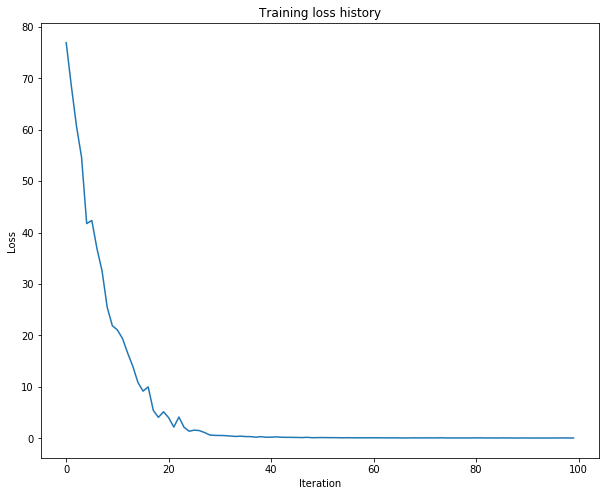

In [60]:
np.random.seed(231)

small_data = load_coco_data(max_train=50)

small_rnn_model = CaptioningRNN(
          cell_type='rnn',
          word_to_idx=data['word_to_idx'],
          input_dim=data['train_features'].shape[1],
          hidden_dim=512,
          wordvec_dim=256,
        )

small_rnn_solver = CaptioningSolver(small_rnn_model, small_data,
           update_rule='adam',
           num_epochs=50,
           batch_size=25,
           optim_config={
             'learning_rate': 5e-3,
           },
           lr_decay=0.95,
           verbose=True, print_every=10,
         )

small_rnn_solver.train()

# Plot the training losses
plt.plot(small_rnn_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

# Test-time sampling
Unlike classification models, image captioning models behave very differently at training time and at test time. At training time, we have access to the ground-truth caption, so we feed ground-truth words as input to the RNN at each timestep. At test time, we sample from the distribution over the vocabulary at each timestep, and feed the sample as input to the RNN at the next timestep.

In the file `cs231n/classifiers/rnn.py`, implement the `sample` method for test-time sampling. After doing so, run the following to sample from your overfitted model on both training and validation data. The samples on training data should be very good; the samples on validation data probably won't make sense.

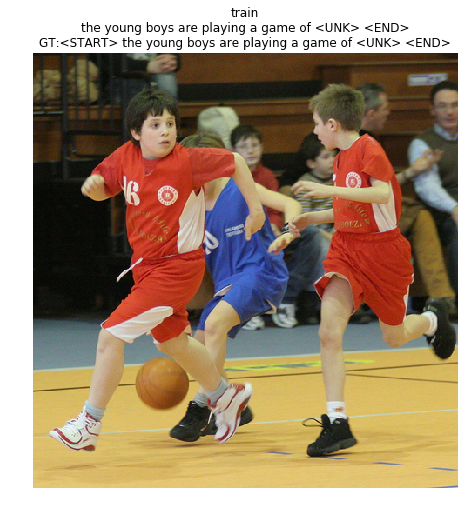

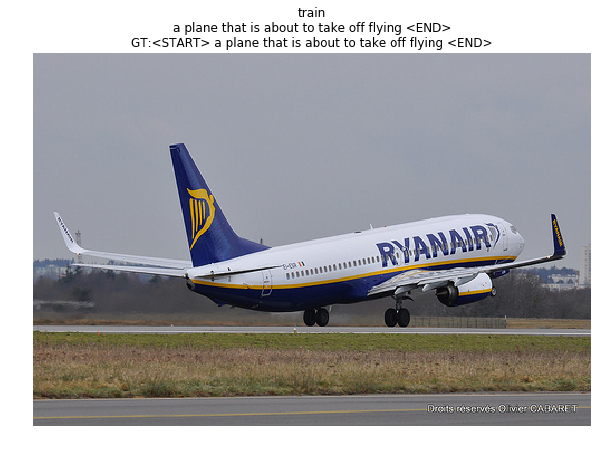

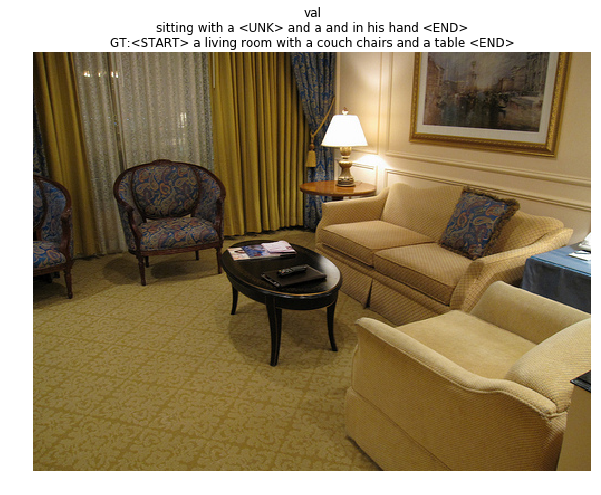

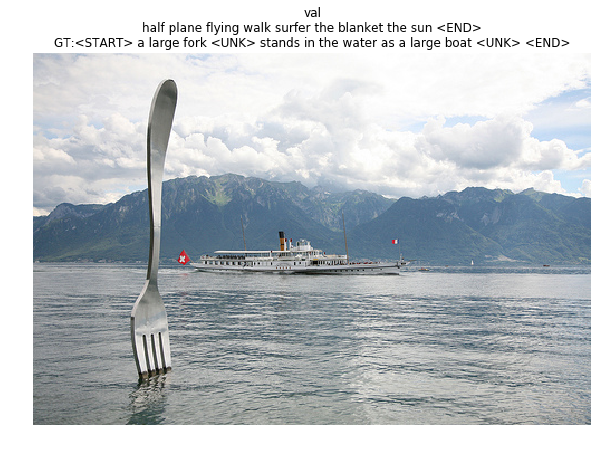

In [70]:
for split in ['train', 'val']:
    minibatch = sample_coco_minibatch(small_data, split=split, batch_size=2)
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])

    sample_captions = small_rnn_model.sample(features)
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])

    for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
        plt.imshow(image_from_url(url))
        plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
        plt.axis('off')
        plt.show()

# INLINE QUESTION 1

In our current image captioning setup, our RNN language model produces a word at every timestep as its output. However, an alternate way to pose the problem is to train the network to operate over _characters_ (e.g. 'a', 'b', etc.) as opposed to words, so that at it every timestep, it receives the previous character as input and tries to predict the next character in the sequence. For example, the network might generate a caption like

'A', ' ', 'c', 'a', 't', ' ', 'o', 'n', ' ', 'a', ' ', 'b', 'e', 'd'

Can you describe one advantage of an image-captioning model that uses a character-level RNN? Can you also describe one disadvantage? HINT: there are several valid answers, but it might be useful to compare the parameter space of word-level and character-level models.

Using words is more expressive and less error-prone. A character-level RNN make mistakes in two ways: error in word composition, error in semantic and  